# GO term and KEGG analysis for featureCounts data
alpha = 0.05, lfcThreshold = 1, altHypothesis = 'greaterAbs'

In [1]:
# loading libraries
library(topGO)
library(KEGGREST)
library(dplyr)
library(clusterProfiler)
library(ggridges)
library(ggplot2)
library(httr)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: graph

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: GO.db

Loading required package: AnnotationDbi

Loading required package: stats4

Load

### I. Clean and prep data frame for analysis
**starting with WARM vs. CONTROL in phase 1 samples (ignoring effects of phase 2)**

#### lfcThreshold=1

In [2]:
# read in the data frame generated from DESeq2
fc_data <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/LFC_FC_sig_p1wc.csv')
dim(fc_data)
head(fc_data)

[1] 13544     7

X            baseMean    log2FoldChange lfcSE     stat      pvalue    padj
1 LOC111120752   0.9171026  0.9897897     1.3692762 0.0000000 1.0000000 NA  
2 LOC111109452   1.3692365  2.0862336     1.6242781 0.6687485 0.5036559 NA  
3 LOC111124802 160.7331187  0.4677914     0.1914082 0.0000000 1.0000000  1  
4 LOC111101273  55.0404755  0.4200722     0.2317512 0.0000000 1.0000000  1  
5 LOC111101250  77.7947775 -0.6155324     0.2079418 0.0000000 1.0000000  1  
6 LOC111101262 188.9039051  0.1706908     0.1825152 0.0000000 1.0000000  1

In [3]:
# selecting only the rows I need for analysis
fc_data2 <- select(fc_data, X, log2FoldChange, padj)

# renaming columns
colnames(fc_data2) <- c('gene', 'lfc', 'padj')

head(fc_data2)

gene         lfc        padj
1 LOC111120752  0.9897897 NA  
2 LOC111109452  2.0862336 NA  
3 LOC111124802  0.4677914  1  
4 LOC111101273  0.4200722  1  
5 LOC111101250 -0.6155324  1  
6 LOC111101262  0.1706908  1

need to create a numeric vector for input into GO and KEGG analysis

according to DESeq analysis, we only have 71 genes that fit our criteria above (p-value < 0.05 and |lfc| > 1, but for KEGG we're doing ranked analysis so we need *all* genes in the data set, not just the ones of interest

going right into KEGG analysis and skipping GO for right now - KEGG seems more relavent

## II. clusterProfiler for KEGG analysis 
again, this data used **lfcThreshold=1**

this package works with entrez IDs and currently our data is associated with accession numbers or ensembl IDs - I use [DAVID web interface](https://david.ncifcrf.gov/conversion2.jsp) to convert IDs

In [4]:
# loading in DAVID conversion txt file
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts analysis/lfc_entrez_convert.txt', sep = '\t')

# renaming columns
colnames(david_df) <- c('gene', 'entrez')

head(david_df)

Warning message in file(file, "rt"):
“cannot open file '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts analysis/lfc_entrez_convert.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
merge_df <- merge(david_df, fc_data2, by = 'gene', all=TRUE)
head(merge_df)

In [ ]:
# omitting any genes with NA for padj
df <- na.omit(merge_df)
dim(df)

In [ ]:
# only selecting the entrezID and lfc columns
kegg_df <- select(df, entrez, lfc)
head(kegg_df)

need to create kegg object for input into clusterProfiler for KEGG analysis

In [ ]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

now doing the actual KEGG analysis [documentation](https://www.rdocumentation.org/packages/clusterProfiler/versions/3.0.4/topics/gseKEGG)

In [ ]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

## **lfcThreshold=1**, no shrinkage

In [ ]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,10)

In [ ]:
ridgeplot(kk2) + labs(x='enrichment distribution')

In [ ]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

In [ ]:
cnetplot(kk2, categorySize="pvalue", foldChange=kegg_gene_list)

## now doing the same thing but with data from **lfcShrink()**

In [ ]:
lfc_shrink <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/lfcshrink_data.csv')
head(lfc_shrink)

In [ ]:
# selecting only the rows I need for analysis
lfc_shrink2 <- select(lfc_shrink, X, log2FoldChange, padj)

# renaming columns
colnames(lfc_shrink2) <- c('gene', 'lfc', 'padj')

head(lfc_shrink2)

In [ ]:
# loading in DAVID conversion txt file
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts analysis/lfc_shrink_conert.txt', sep = '\t')

# renaming columns
colnames(david_df) <- c('gene', 'entrez')

head(david_df)

In [ ]:
merge_df <- merge(david_df, lfc_shrink2, by = 'gene', all=TRUE)
head(merge_df)

In [ ]:
# omitting any genes with NA for padj
df <- na.omit(merge_df)
dim(df)

In [ ]:
# only selecting the entrezID and lfc columns
kegg_df <- select(df, entrez, lfc)
head(kegg_df)

need to create kegg object for input into clusterProfiler for KEGG analysis

In [ ]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

## KEGG analysis with **LFC SHRINK** (no lfcThreshold)

still using the same set of samples - warm vs. control for phase 1 but now ***not*** using an lfcThreshold level, only lfcShrink() function

now doing the actual KEGG analysis [documentation](https://www.rdocumentation.org/packages/clusterProfiler/versions/3.0.4/topics/gseKEGG)

In [ ]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

In [ ]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,10)

interesting because we now we're seeing statistically significant pathways (q-value below 0.2)

In [ ]:
ridgeplot(kk2) + labs(x='enrichment distribution')

In [ ]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

In [ ]:
cnetplot(kk2, categorySize="pvalue", foldChange=kegg_gene_list)

## KEGG analysis for lfcThreshold=0.5 
again, using the same set of samples (phase 1 warm vs. control) but changing lfcThreshold to 0.5, and no lfcShrink()

alpha = 0.05, lfcThreshold = 0.5, altHypothesis = 'greaterAbs'

In [ ]:
data = read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts_analysis/lfc0.5_genes_wc.txt')
head(data)

# grabbing only the columns I need
data2 <- select(data, X, log2FoldChange, padj)

# renaming columns 
colnames(data2) <- c('gene','lfc','padj')
head(data2)

In [ ]:
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts_analysis/david_convert_lfc0.5.txt', sep='\t')
colnames(david_df) <- c('gene','entrez')
head(david_df)

In [ ]:
merge_df <- merge(david_df, data2, by = 'gene', all=TRUE)
head(merge_df)

In [ ]:
# omitting any genes with NA for padj
df <- na.omit(merge_df)
dim(df)

In [ ]:
# only selecting the entrezID and lfc columns
kegg_df <- select(df, entrez, lfc)
head(kegg_df)

need to create kegg object for input into clusterProfiler for KEGG analysis

In [ ]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

## **lfcThreshold=0.5**, but no shrinkage

In [ ]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

In [ ]:
gseaKEGG_results <- kk2@result

In [ ]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,10)

interesting because we now we're seeing statistically significant pathways (q-value below 0.2)

In [ ]:
ridgeplot(kk2) + labs(x='enrichment distribution')

In [ ]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

In [ ]:
cnetplot(kk2, categorySize="pvalue", foldChange=kegg_gene_list)

## KEGG analysis for lfcShrink and lfcThreshold=0.5
for phase 1 warm vs. control

In [ ]:
lfc_shrink <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts_analysis/normalshr_lfcthreshold_p1wc.txt', sep=',')
head(lfc_shrink)

In [ ]:
# grabbing only the columns of interest
lfc_shrink2 <- select(lfc_shrink, X, log2FoldChange, padj)

# renaming columns to make more sense/easier
colnames(lfc_shrink2) <- c('gene', 'lfc', 'padj')

head(lfc_shrink2)

need to convert these gene IDs to entrez IDs for KEGG - downloading dataframe, plugging genes into DAVID converter, and uploading df here

In [ ]:
# read in conversion dataframe from DAVID
convert_id <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts_analysis/david_lfc_shrink_convert.txt', sep='\t')

# grab only the columns we need
convert_id <- select(convert_id, From, To)

# renaming columns 
colnames(convert_id) <- c('gene', 'entrez')

head(convert_id)

In [ ]:
# merging the dataframe from DESeq with the conversion IDs
merge_df <- merge(convert_id, lfc_shrink2, by = 'gene', all=TRUE)

# get rid of rows with NA for padj
merge_df <- na.omit(merge_df)

head(merge_df)

In [ ]:
# only selecting columns needed for KEGG analysis
kegg_df <- select(merge_df, entrez, lfc)
head(kegg_df)

In [ ]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

### lfcShrink (normal) and lfcThreshold=0.5

In [ ]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

In [ ]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,15)

In [ ]:
write.csv(kk2_df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p1_wc_pathway.csv')

In [ ]:
# removes extra info on description column
kk2@result$Description <- gsub(pattern = " - Crassostrea virginica (eastern oyster)", 
                                 replacement = "", kk2@result$Description, fixed = T)
head(kk2)

In [ ]:
# changes size of plots
options(repr.plot.width=10, repr.plot.height=15)

In [ ]:
ridgeplot(kk2) + labs(x='enrichment distribution')

In [ ]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)
# activated = more methylation in warming
# suppressed = more methylation in control

trying KEGG lfcshrink and lfcthreshold=0.5 for phase 1 warm vs. control WITHOUT filtering out padj=NA - seeing what difference it makes to see if we want to keep it

In [ ]:
# merging the dataframe from DESeq with the conversion IDs
merge_df <- merge(convert_id, lfc_shrink2, by = 'gene', all=TRUE)

# get rid of rows with NA for padj
#merge_df <- na.omit(merge_df)

head(merge_df)

In [ ]:
# only selecting columns needed for KEGG analysis
kegg_df <- select(merge_df, entrez, lfc)
head(kegg_df)

In [ ]:
# creating numeric vector with entrez ID and associated log2foldchange
kegg_gene_list <- kegg_df$lfc
names(kegg_gene_list) <- kegg_df$entrez

# omit any NA values
#kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list) # numeric vector

### lfcShrink (normal) and lfcThreshold=0.5

In [ ]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

In [ ]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,15)

In [ ]:
# removes extra info on description column
kk2@result$Description <- gsub(pattern = " - Crassostrea virginica (eastern oyster)", 
                                 replacement = "", kk2@result$Description, fixed = T)
head(kk2)

In [ ]:
# changes size of plots
options(repr.plot.width=10, repr.plot.height=15)

In [ ]:
ridgeplot(kk2) + labs(x='enrichment distribution')

In [ ]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)
# activated = more methylation in warming
# suppressed = more methylation in control

## KEGG analysis of Hypoxic CE in oysters
looking at the two data sets of oysters who experienced control for phase 1 and hypoxic/control for phase 2 and compare to oysters who experienced hypoxia for phase 1 and hypoxic/control for phase 2

- lfcShrink = normal
- lfcThreshold = 0.5
- alpha = 0.05

In [ ]:
# load in data frame
p1h <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts_analysis/p1h_shrink_lfcthreshold.txt')

# select only needed columns
p1h_df <- select(p1h, X, log2FoldChange, padj)

# renaming columns
colnames(p1h_df) <- c('gene', 'lfc', 'padj')

head(p1h_df)

In [ ]:
# load in entrez ID conversion
convert <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/featureCounts_analysis/p1h_convert.txt', sep = '\t')

# select only the columns I need
convert_df <- select(convert, From, To)

# rename columns
colnames(convert_df) <- c('gene', 'entrez')

head(convert_df)

In [ ]:
# merge df together to convert gene IDs to entrez
merge_df <- merge(convert_df, p1h_df, by='gene', all=TRUE)

# omit any row with NA
merge_df <- na.omit(merge_df)

# only select columns I need now
merge_df <- select(merge_df, entrez, lfc)

head(merge_df)

In [ ]:
# creating numeric vector for kegg object
kegg_gene_list <- merge_df$lfc
names(kegg_gene_list) <- merge_df$entrez

# sort list in descending order
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list)

In [ ]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

In [ ]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,15)

In [ ]:
# removes extra info on description column
kk2@result$Description <- gsub(pattern = " - Crassostrea virginica (eastern oyster)", 
                                 replacement = "", kk2@result$Description, fixed = T)
head(kk2)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

In [ ]:
ridgeplot(kk2) + labs(x='enrichment distribution')

In [ ]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

# ALL EXPERIENCED PHASE 1 HYPOXIA
# activated = more methylation in phase 2 hypoxic
# suppressed = more methylation in phase 2 control

## unfiltered DESeq KEGG analysis
still looking at significantly differentially methylated genes for phase 1 warm vs. control, but now genes get assigned NA for adjusted p-values *only* when the gene has low counts (so this now includes outliers, instead of assigning outliers NA), therefore, different genes will be kept in the analysis for enriched pathways

looking at **phase 1 warm vs. control**

In [2]:
# load in data frame
#unfiltered_p1wc <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/unfiltered_lfc_p1wc.csv')

# using a diff df - this one is unfiltered, lfcThreshold=0.25, lfc_shrink = normal
unfiltered_p1wc <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_sig_genes/p1wc_lfc25_genes.csv')

# select only needed columns
unfilter_df <- select(unfiltered_p1wc, X, log2FoldChange, padj)

# KEGG uses entrez IDs, which are my ensembl IDs without the 'LOC' in front of them, so need to convert those
unfilter_df$X <- substr(unfilter_df$X, start = 4, stop = nchar(unfilter_df$X))

# renaming columns
colnames(unfilter_df) <- c('gene', 'lfc', 'padj')

head(unfilter_df)

gene      lfc        padj     
1 111120752  0.5117345        NA
2 111109452  1.0072548        NA
3 111124802  0.4591660 1.0000000
4 111101273  0.4055670 1.0000000
5 111101250 -0.6027753 0.6036878
6 111101262  0.1674635 1.0000000

In [3]:
# creating numeric vector for kegg object
kegg_gene_list <- unfilter_df$lfc
names(kegg_gene_list) <- unfilter_df$gene

# omitting anything with NA in a cell
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list)

111116233 111128351 111111687 111136151 111127409 111133219 
 4.846533  4.571313  4.519728  4.399718  4.252964  4.031328

[1] "numeric"

In [4]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

Reading KEGG annotation online: "https://rest.kegg.jp/link/cvn/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/cvn"...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.05% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [5]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,15)

ID       Description                                setSize
cvn00053 cvn00053 Ascorbate and aldarate metabolism           12    
cvn00910 cvn00910 Nitrogen metabolism                         10    
cvn00511 cvn00511 Other glycan degradation                    37    
cvn00052 cvn00052 Galactose metabolism                        21    
cvn00592 cvn00592 alpha-Linolenic acid metabolism             11    
cvn03250 cvn03250 Viral life cycle                            28    
cvn00071 cvn00071 Fatty acid degradation                      38    
cvn00380 cvn00380 Tryptophan metabolism                       31    
cvn03015 cvn03015 mRNA surveillance pathway                   61    
cvn04814 cvn04814 Motor proteins                             111    
cvn03013 cvn03013 Nucleocytoplasmic transport                 92    
cvn04144 cvn04144 Endocytosis                                132    
cvn00280 cvn00280 Valine, leucine and isoleucine degradation  50    
cvn04310 cvn04310 Wnt signaling pathway                       68    
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids     18    
         enrichmentScore NES      pvalue      p.adjust  qvalue    rank
cvn00053 0.7513381       1.647357 0.005464596 0.1919960 0.1703662 2374
cvn00910 0.7751841       1.635015 0.005504478 0.1919960 0.1703662 1398
cvn00511 0.5917499       1.592294 0.011186436 0.1919960 0.1703662 2221
cvn00052 0.6484812       1.587363 0.011072080 0.1919960 0.1703662 2261
cvn00592 0.7377666       1.578957 0.017454181 0.1919960 0.1703662 1602
cvn03250 0.6023539       1.547657 0.017181028 0.1919960 0.1703662 2628
cvn00071 0.5657277       1.532021 0.017197187 0.1919960 0.1703662 3018
cvn00380 0.5838480       1.528613 0.014020252 0.1919960 0.1703662 2374
cvn03015 0.5361300       1.524219 0.010182324 0.1919960 0.1703662 1968
cvn04814 0.4825362       1.444184 0.005506763 0.1919960 0.1703662 1179
cvn03013 0.4748788       1.403291 0.011084921 0.1919960 0.1703662 3059
cvn04144 0.4453777       1.346500 0.022324161 0.2251020 0.1997425 3185
cvn00280 0.5161748       1.438034 0.029019899 0.2569002 0.2279584 2374
cvn04310 0.4841371       1.394692 0.029723992 0.2569002 0.2279584 3740
cvn01040 0.6354291       1.517839 0.034925083 0.2713004 0.2407364 1602
         leading_edge                  
cvn00053 tags=58%, list=18%, signal=48%
cvn00910 tags=50%, list=10%, signal=45%
cvn00511 tags=30%, list=16%, signal=25%
cvn00052 tags=38%, list=17%, signal=32%
cvn00592 tags=45%, list=12%, signal=40%
cvn03250 tags=46%, list=19%, signal=37%
cvn00071 tags=42%, list=22%, signal=33%
cvn00380 tags=42%, list=18%, signal=35%
cvn03015 tags=36%, list=15%, signal=31%
cvn04814 tags=18%, list=9%, signal=17% 
cvn03013 tags=34%, list=23%, signal=26%
cvn04144 tags=33%, list=24%, signal=25%
cvn00280 tags=28%, list=18%, signal=23%
cvn04310 tags=44%, list=28%, signal=32%
cvn01040 tags=33%, list=12%, signal=29%
         core_enrichment                                                                                                                                                                                                                                                                                                                                                                                                                              
cvn00053 111124535/111103451/111124599/111127562/111112920/111115614/111103498                                                                                                                                                                                                                                                                                                                                                                        
cvn00910 111134700/111100398/111100399/111126492/111135592                                                                                                                                                                                                 

In [6]:
# removes extra info on description column
kk2@result$Description <- gsub(pattern = " - Crassostrea virginica (eastern oyster)", 
                                 replacement = "", kk2@result$Description, fixed = T)
head(kk2)

ID       Description                       setSize enrichmentScore
cvn00053 cvn00053 Ascorbate and aldarate metabolism 12      0.7513381      
cvn00910 cvn00910 Nitrogen metabolism               10      0.7751841      
cvn00511 cvn00511 Other glycan degradation          37      0.5917499      
cvn00052 cvn00052 Galactose metabolism              21      0.6484812      
cvn00592 cvn00592 alpha-Linolenic acid metabolism   11      0.7377666      
cvn03250 cvn03250 Viral life cycle - HIV-1          28      0.6023539      
         NES      pvalue      p.adjust qvalue    rank
cvn00053 1.647357 0.005464596 0.191996 0.1703662 2374
cvn00910 1.635015 0.005504478 0.191996 0.1703662 1398
cvn00511 1.592294 0.011186436 0.191996 0.1703662 2221
cvn00052 1.587363 0.011072080 0.191996 0.1703662 2261
cvn00592 1.578957 0.017454181 0.191996 0.1703662 1602
cvn03250 1.547657 0.017181028 0.191996 0.1703662 2628
         leading_edge                  
cvn00053 tags=58%, list=18%, signal=48%
cvn00910 tags=50%, list=10%, signal=45%
cvn00511 tags=30%, list=16%, signal=25%
cvn00052 tags=38%, list=17%, signal=32%
cvn00592 tags=45%, list=12%, signal=40%
cvn03250 tags=46%, list=19%, signal=37%
         core_enrichment                                                                                                                  
cvn00053 111124535/111103451/111124599/111127562/111112920/111115614/111103498                                                            
cvn00910 111134700/111100398/111100399/111126492/111135592                                                                                
cvn00511 111106921/111106925/111106928/111119851/111119435/111120040/111113388/111119434/111106926/111119431/111106930                    
cvn00052 111101197/111118471/111101820/111113388/111109442/111099882/111120703/111118006                                                  
cvn00592 111113990/111115744/111107112/111115745/111124908                                                                                
cvn03250 111124701/111124696/111129825/111111579/111108190/111135084/111128997/111124977/111106750/111123417/111130886/111104027/111135329

In [7]:
# saving enriched pathways info into csv file to further investigate 
write.csv(kk2, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/unfiltered_pathways_p1wc.csv')

In [8]:
options(repr.plot.width=10, repr.plot.height=10)

Picking joint bandwidth of 0.279



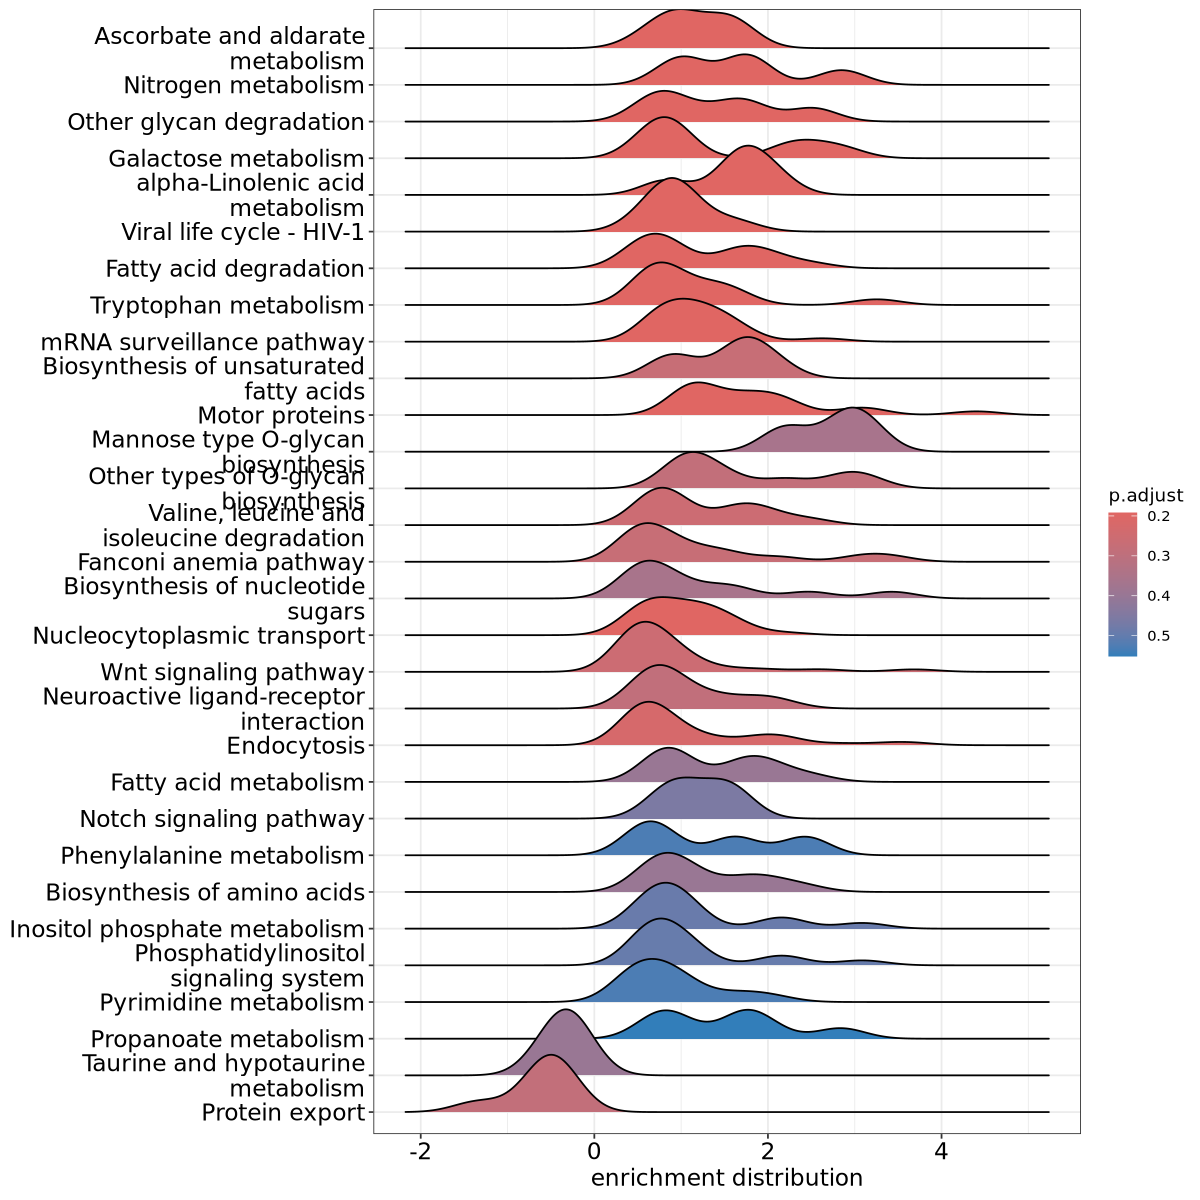

In [9]:
ridgeplot(kk2) + labs(x='enrichment distribution')

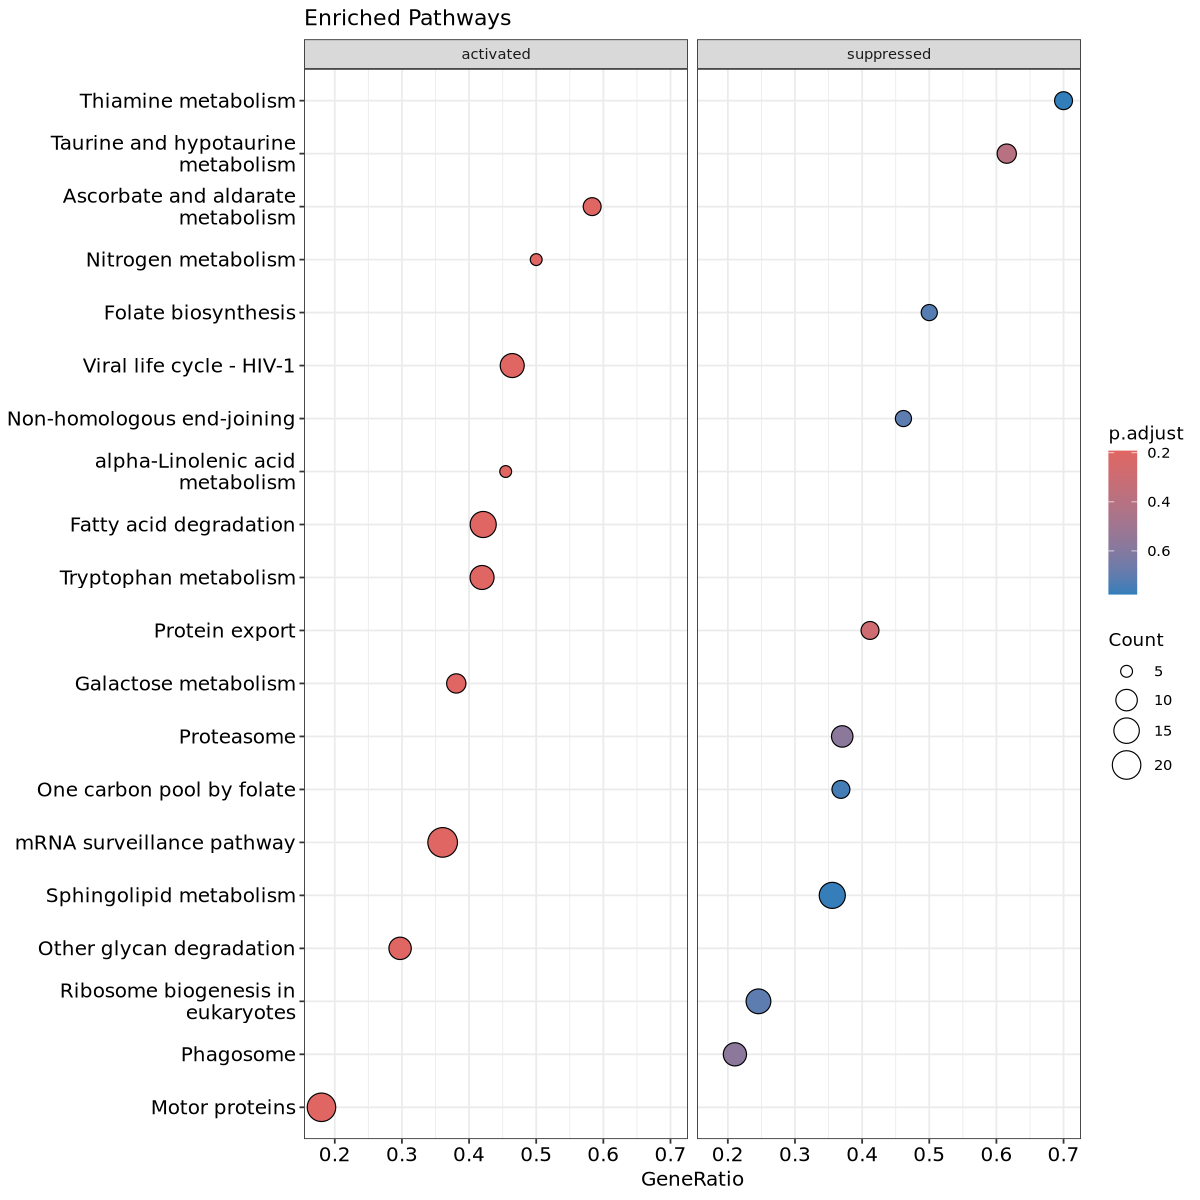

In [10]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

# activated = more methylation in phase 1 warming
# suppressed = more methylation in phase 1 control

## Connecting KEGG ID to Pathway Info
From gseKEGG and in the kk2 dataframe, we can these KEGG IDs cvn##### - these correspond to the specific KEGG pathway. KEGG has hierarchel pathways, and it's useful to know what broader pathway our pathway might belong too (metabolism? organismal systems? etc...) so from help with ChatGPT, you can have R go to the URL link with info from the KEGG ID, read the line with 'CLASS' and interpret that to form new columns including our general pathway and more detailed pathway.

I've turned the code below into markdown text - runs for a long time, so after first run you should save the data frame as a csv to be able to call it when you run this again.

**function to get pathway meta data from URL link:**


In [11]:

# generated with help of ChatGPT
# Function to get pathway names
get_pathway_names <- function(kegg_id) {
  url <- paste0("http://rest.kegg.jp/get/", kegg_id)
  response <- GET(url)
  
  if (status_code(response) == 200) {
    pathway_info <- content(response, "text", encoding = "UTF-8")
    general_pathway <- NA
    detailed_pathway <- NA
    
    # Extracting general and detailed pathways from the pathway info
    lines <- strsplit(pathway_info, "\n")[[1]]
    for (line in lines) {
      if (grepl("^CLASS", line)) {
        paths <- unlist(strsplit(line, ";"))
        general_pathway <- trimws(paths[1])
        detailed_pathway <- ifelse(length(paths) > 1, trimws(paths[2]), NA)
        break
      }
    }
    
    return(list(General_Pathway = general_pathway, Detailed_Pathway = detailed_pathway))
  } else {
    cat("Failed to retrieve information for pathway:", kegg_id, "\n")
    return(NULL)
  }
}


**adding pathway meta data to data frame**

In [12]:

# generated with help of ChatGPT
# Sample dataframe with KEGG IDs
gseKEGG_df <- select(kk2_df, ID, Description, enrichmentScore)

# Function to apply to each KEGG ID in the dataframe
pathway_info <- lapply(gseKEGG_df$ID, get_pathway_names)

# Combine pathway info into a dataframe
pathway_df <- do.call(rbind, pathway_info)
colnames(pathway_df) <- c('GeneralPathway', 'DetailedPathway')

# Combine pathway info with original dataframe
gseKEGG_df <- cbind(gseKEGG_df, pathway_df)

# Rename columns for clarity
#colnames(gseKEGG_df) <- c("KEGG_ID", "General_Pathway", "Detailed_Pathway")

# Print the dataframe
head(as.data.frame(gseKEGG_df))


ID       Description                       enrichmentScore
cvn00053 cvn00053 Ascorbate and aldarate metabolism 0.7513381      
cvn00910 cvn00910 Nitrogen metabolism               0.7751841      
cvn00511 cvn00511 Other glycan degradation          0.5917499      
cvn00052 cvn00052 Galactose metabolism              0.6484812      
cvn00592 cvn00592 alpha-Linolenic acid metabolism   0.7377666      
cvn03250 cvn03250 Viral life cycle                  0.6023539      
         GeneralPathway DetailedPathway
cvn00053 CLASS   ....   Carbohyd....   
cvn00910 CLASS   ....   Energy m....   
cvn00511 CLASS   ....   Glycan b....   
cvn00052 CLASS   ....   Carbohyd....   
cvn00592 CLASS   ....   Lipid me....   
cvn03250 CLASS   ....   Informat....

now need to **clean up data frame**

In [13]:

df <- as.data.frame(gseKEGG_df)
# cleaning up GeneralPathway column to only include the pathway name and not CLASS
column <- df$GeneralPathway
column <- gsub('^CLASS\\s+', '', column)
df$GeneralPathway <- column

# also changing DetailedPathway into character instead of list to be able to write csv
df$DetailedPathway <- as.character(df$DetailedPathway)

head(df)


ID       Description                       enrichmentScore
cvn00053 cvn00053 Ascorbate and aldarate metabolism 0.7513381      
cvn00910 cvn00910 Nitrogen metabolism               0.7751841      
cvn00511 cvn00511 Other glycan degradation          0.5917499      
cvn00052 cvn00052 Galactose metabolism              0.6484812      
cvn00592 cvn00592 alpha-Linolenic acid metabolism   0.7377666      
cvn03250 cvn03250 Viral life cycle                  0.6023539      
         GeneralPathway                 DetailedPathway                   
cvn00053 Metabolism                     Carbohydrate metabolism           
cvn00910 Metabolism                     Energy metabolism                 
cvn00511 Metabolism                     Glycan biosynthesis and metabolism
cvn00052 Metabolism                     Carbohydrate metabolism           
cvn00592 Metabolism                     Lipid metabolism                  
cvn03250 Genetic Information Processing Information processing in viruses

In [14]:

# write csv file
write.csv(df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p1wc_lfc25_kegg_pathway.csv')


In [27]:
# after running above code once, can just call df from csv file
df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p1wc_kegg_pathway.csv')

### ggplot of pathways
With this information/meta data on the pathways, I want to do some analysis and try to generate some barplots/histograms

In [15]:
# taking out NAs
df2 <- filter(df, df$GeneralPathway!='NA')

In [16]:
options(repr.plot.width=20, repr.plot.height=10)

just plotting the data to check it out first

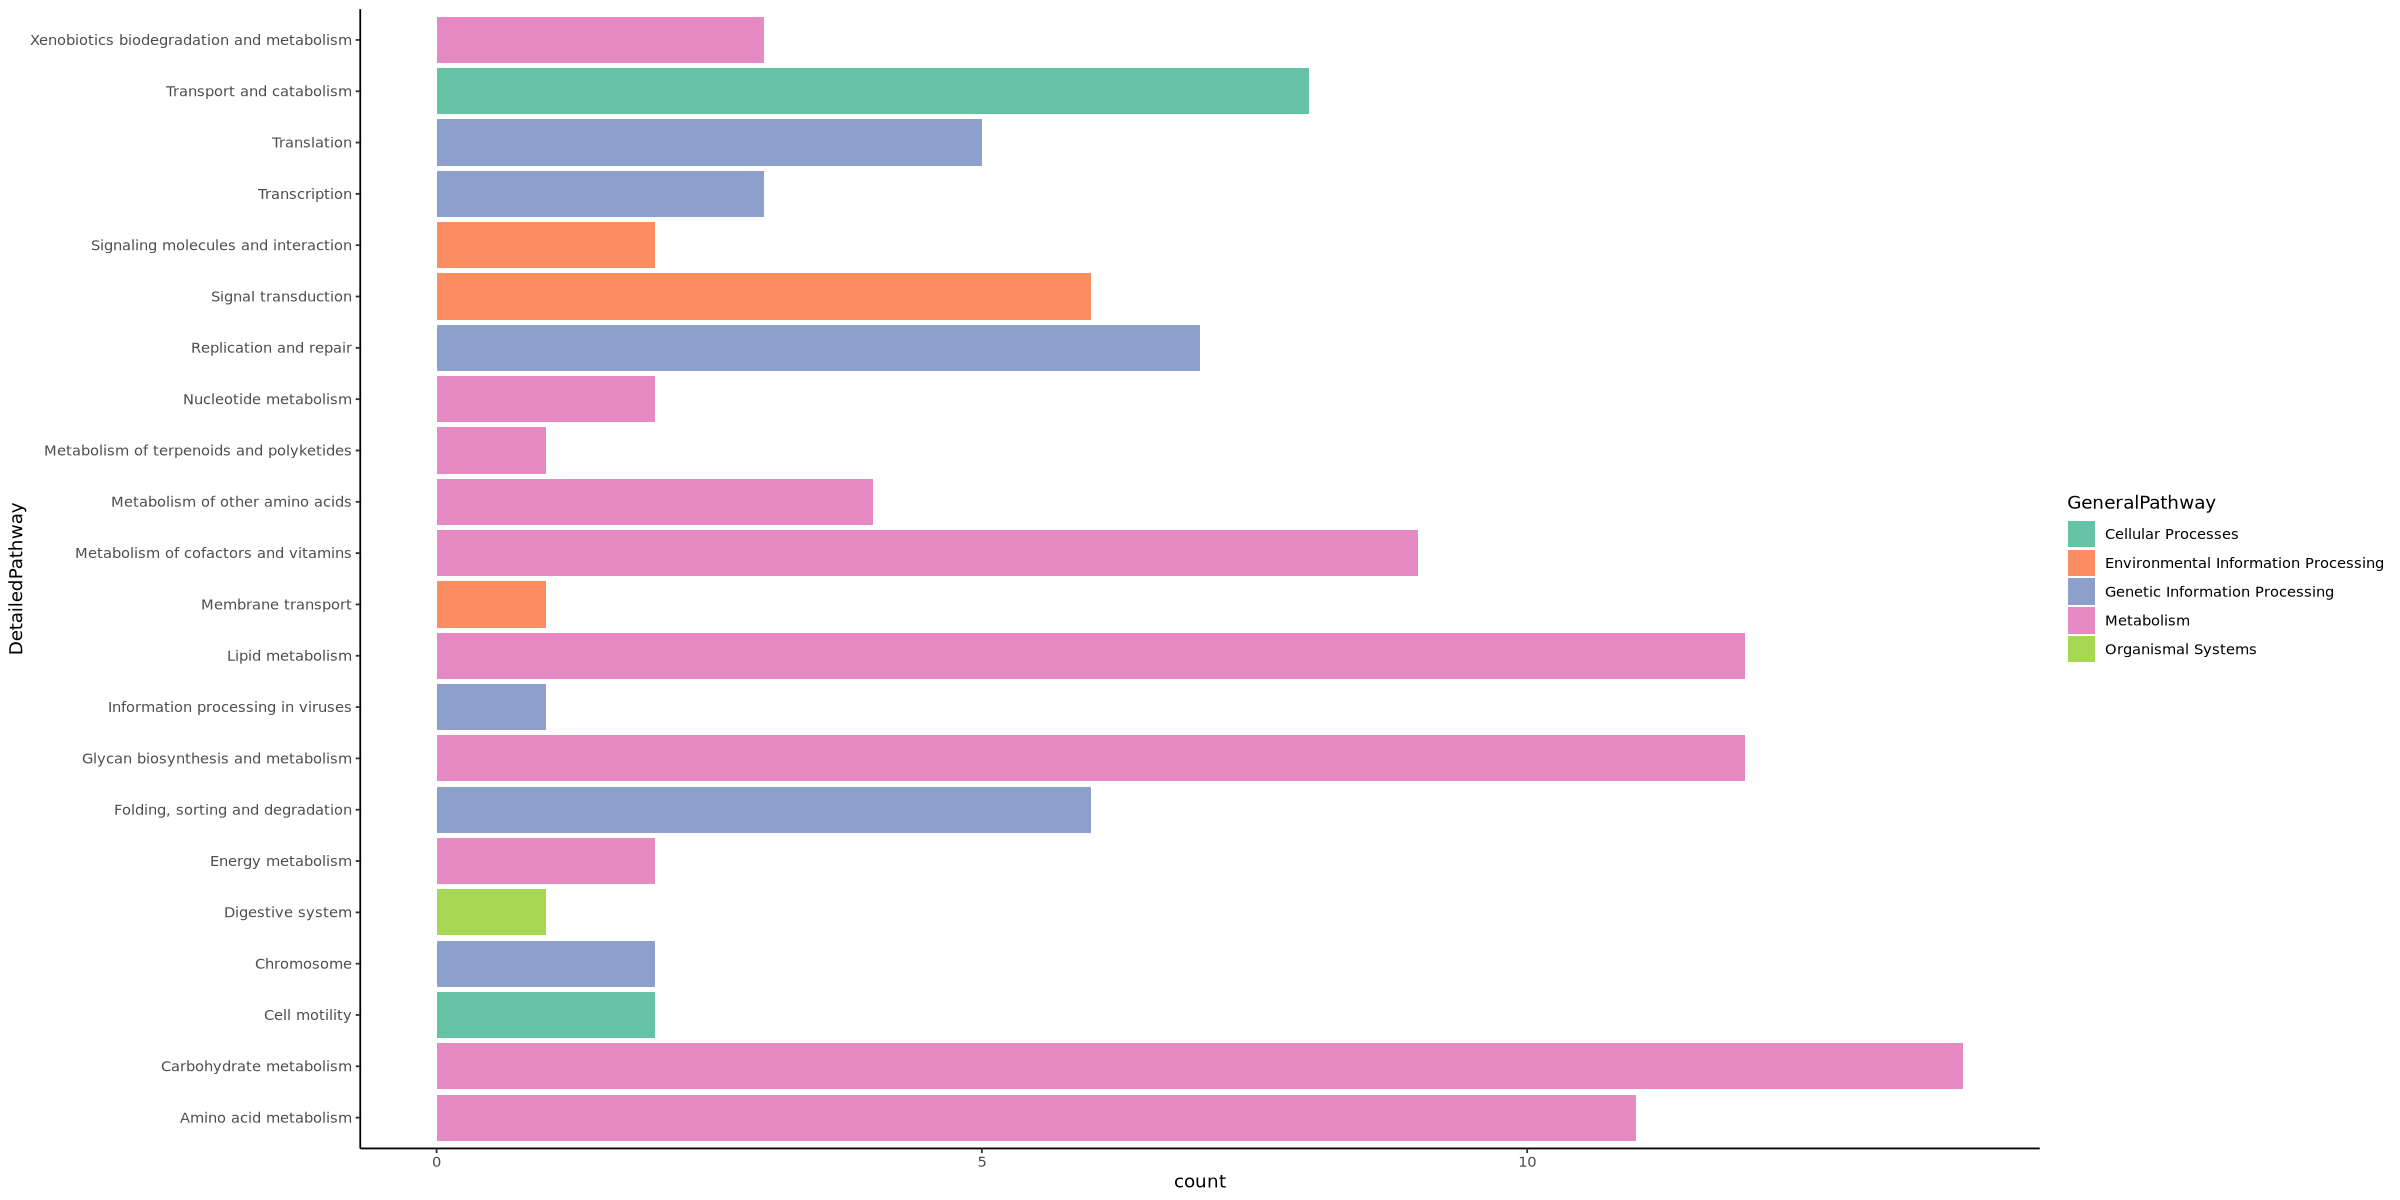

In [17]:
ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar() + 
coord_flip() +
theme_classic() + 
scale_fill_brewer(palette = 'Set2')

want to get the same general pathway bars next to each other 

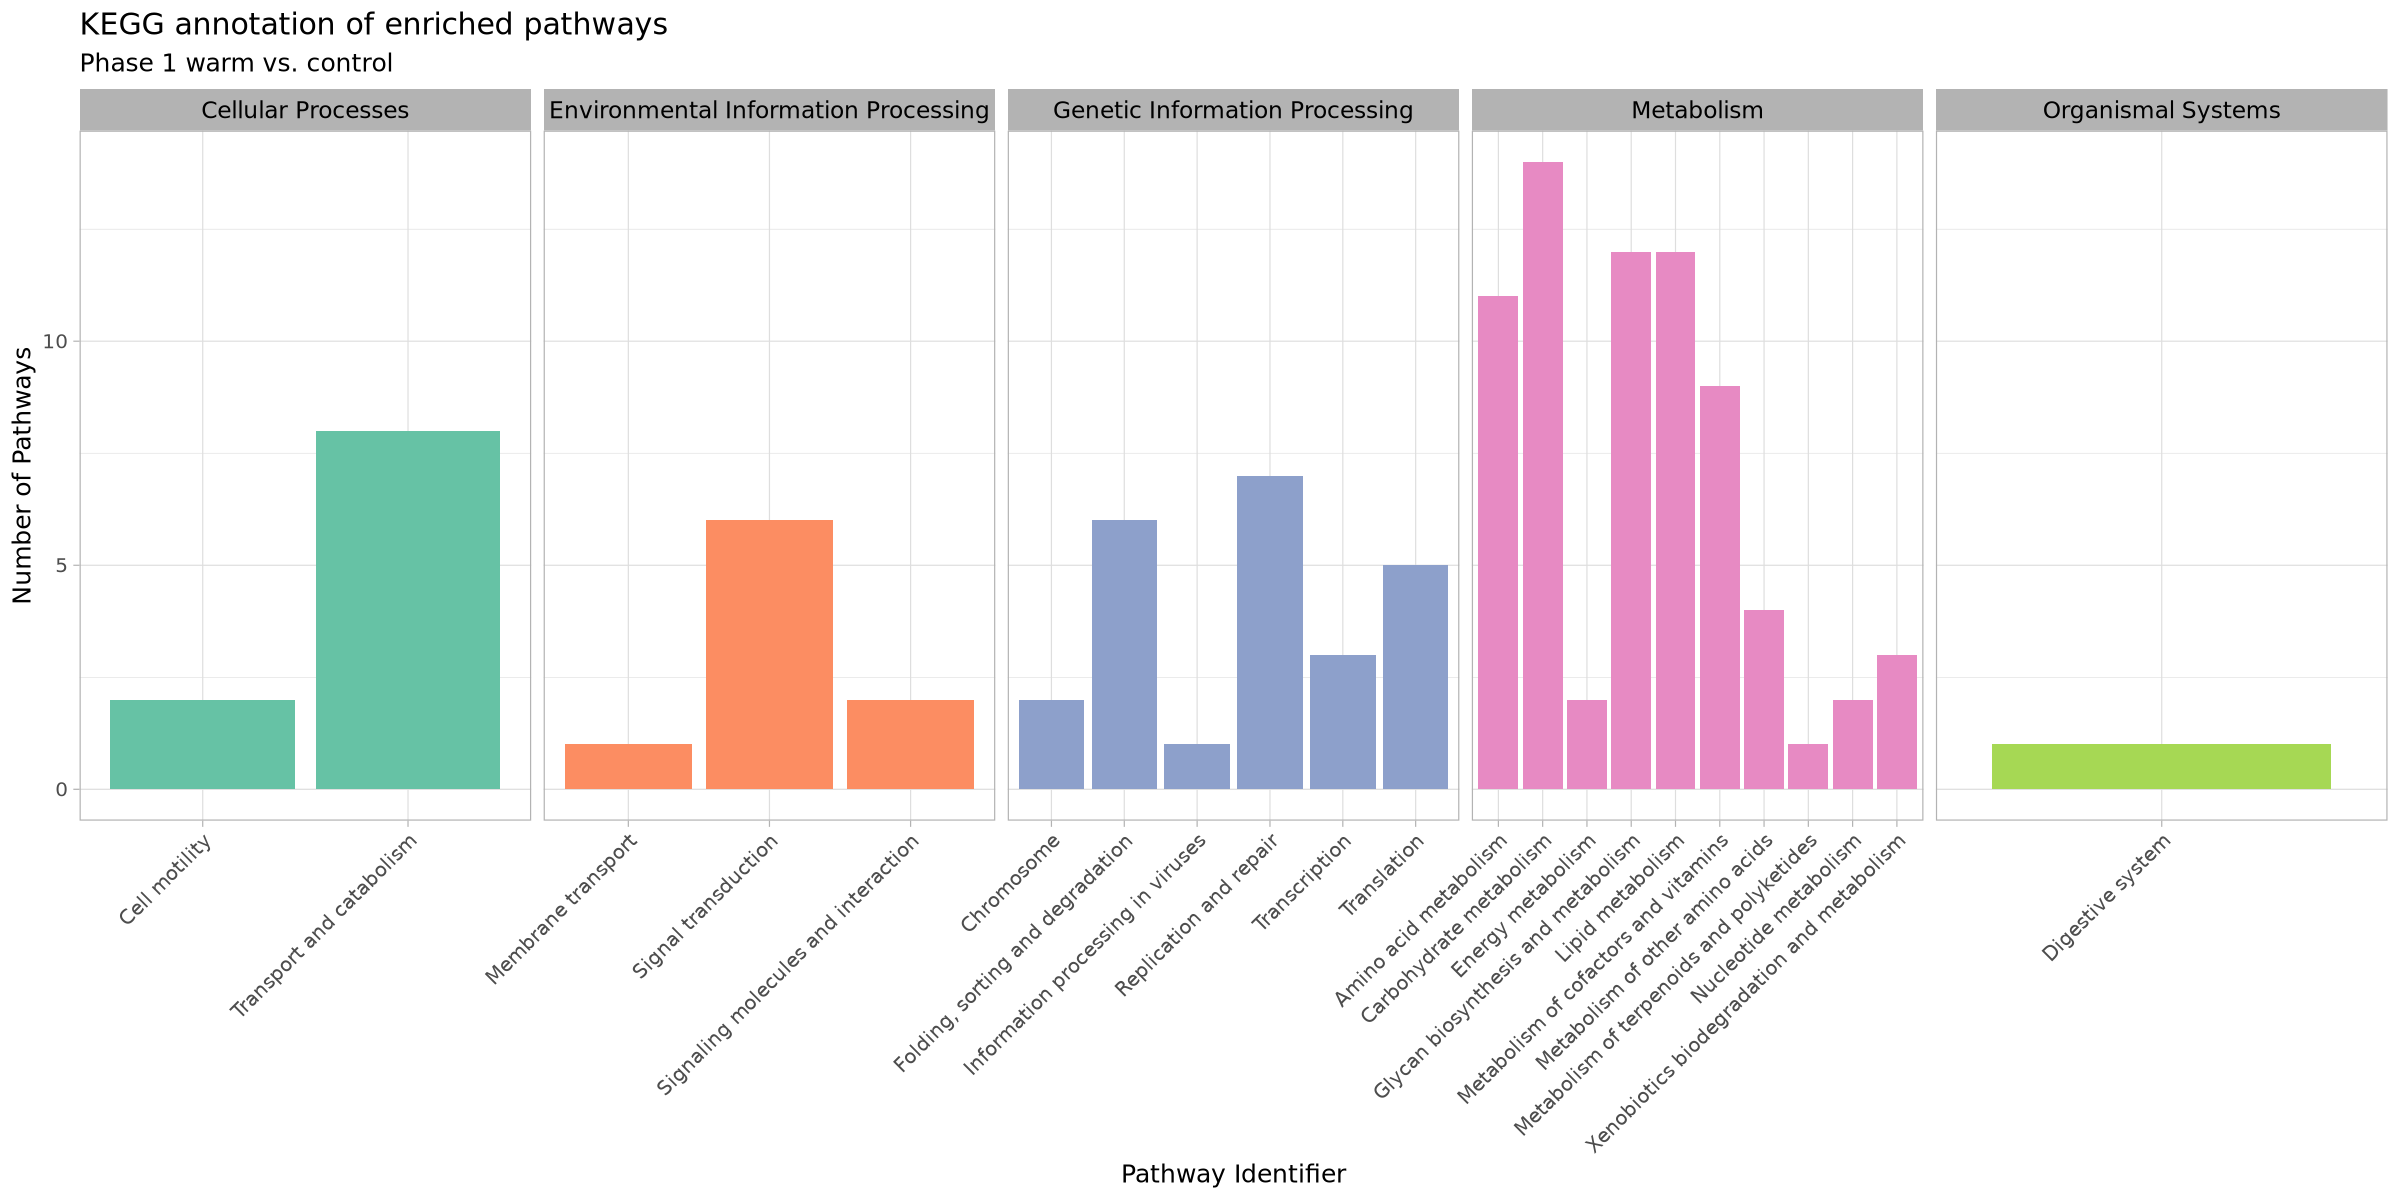

In [18]:
ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar(show.legend=FALSE) + 
#coord_flip() +
theme_light(base_size=15) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(~GeneralPathway, scales='free') +
theme(axis.text.x = element_text(angle = 45, hjust=1)) +
labs(title = 'KEGG annotation of enriched pathways', subtitle = 'Phase 1 warm vs. control', y = 'Number of Pathways', 
    x = 'Pathway Identifier')

now want to add directionality... the above plot has both warm and control pathways put together, so want to separate those out

In [19]:
# making sure R see enrichment score as a number
df2$enrichmentScore <- as.numeric(df2$enrichmentScore)

# assigning the enriched pathway to a phase based on the enrichment score
df2$direction <- ifelse(df2$enrichmentScore<0, "control", #neg ES = pathway for control
        ifelse(df2$enrichmentScore>0, "warm", # pos ES = pathway for warm
        "neutral")) # don't need this, but example online had it and I can't figure out how to do this otherwise

head(df2)

ID       Description                       enrichmentScore
cvn00053 cvn00053 Ascorbate and aldarate metabolism 0.7513381      
cvn00910 cvn00910 Nitrogen metabolism               0.7751841      
cvn00511 cvn00511 Other glycan degradation          0.5917499      
cvn00052 cvn00052 Galactose metabolism              0.6484812      
cvn00592 cvn00592 alpha-Linolenic acid metabolism   0.7377666      
cvn03250 cvn03250 Viral life cycle                  0.6023539      
         GeneralPathway                 DetailedPathway                   
cvn00053 Metabolism                     Carbohydrate metabolism           
cvn00910 Metabolism                     Energy metabolism                 
cvn00511 Metabolism                     Glycan biosynthesis and metabolism
cvn00052 Metabolism                     Carbohydrate metabolism           
cvn00592 Metabolism                     Lipid metabolism                  
cvn03250 Genetic Information Processing Information processing in viruses 
         direction
cvn00053 warm     
cvn00910 warm     
cvn00511 warm     
cvn00052 warm     
cvn00592 warm     
cvn03250 warm

creating another ggplot, but this time adding phase variable to the facet grid so we can see what pathways were methylated for each phase

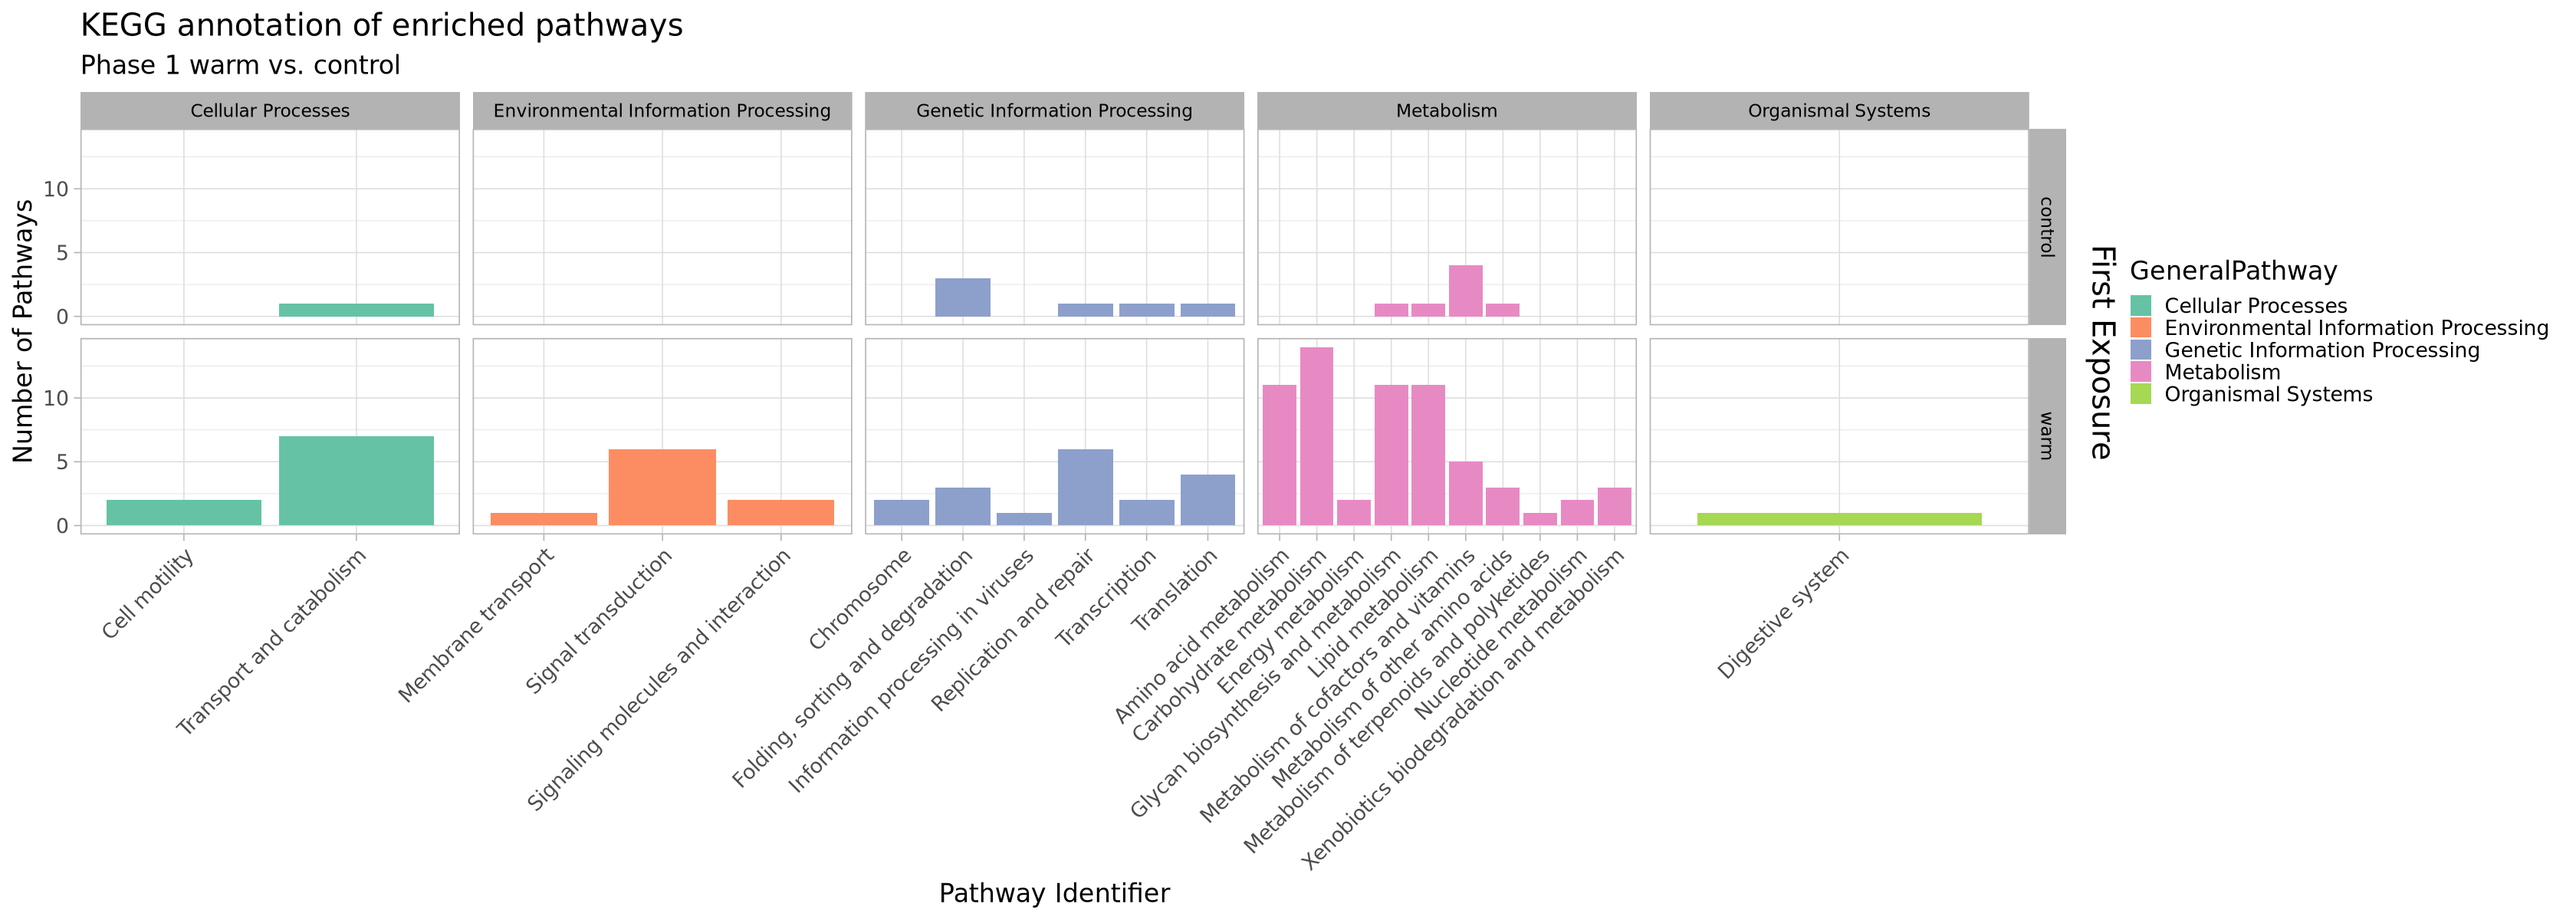

In [72]:
p1_wc_kegg_plot <- ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar() + 
#coord_flip() +
theme_light(base_size=20) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(direction~GeneralPathway, scales='free_x') +
theme(axis.text.x = element_text(angle = 45, hjust=1), 
      legend.box.margin=margin(l=20),
      plot.tag=element_text(angle=-90),
      plot.tag.position=c(0.82, 0.62)) +
labs(title = 'KEGG annotation of enriched pathways', subtitle = 'Phase 1 warm vs. control', y = 'Number of Pathways', 
    x = 'Pathway Identifier', tag='First Exposure')

p1_wc_kegg_plot

In [68]:
options(repr.plot.width=28, repr.plot.height=10)

I think this is really interesting to see only warming treatment had methylated environmental information processing, maybe triggerring that cascade of genes in response to stress?

In [66]:
# saving plot as pdf file

# open pdf file
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures')
pdf('p1_wc_kegg_pathways.pdf', width=25, height=10)

# open plot
p1_wc_kegg_plot

# close pdf file
dev.off()

png 
  2

### How many of my genes are in each pathway?
Extracting the genes in each pathway, and seeing how many of my significant genes are in that pathway

will add these numbers to the OG dataframe to replicate bar plot above, but with total number of sig genes for the x axis (instead of number of pathways)

In [83]:
# filtering df for only genes that were significant
sig_genes <- filter(unfilter_df, unfilter_df$padj < 0.05)
dim(sig_genes) #344 total genes
head(sig_genes)

[1] 344   3

gene      lfc      padj       
1 111117672 1.314266 0.005811498
2 111128103 1.644558 0.001509994
3 111137770 2.655903 0.002201055
4 111125333 1.461069 0.017320572
5 111111295 2.360240 0.001233208
6 111125391 2.205531 0.001875643

In [84]:
id <- kk2$ID
pathways <- kk2$ID
genes <- geneInCategory(kk2)[id]

# Your significant genes
significant_genes <- sig_genes$gene

# Create an empty data frame to store the results
result_df <- data.frame(Pathway = character(), Significant_Genes_Count = numeric(), stringsAsFactors = FALSE)

# Loop through each pathway
for (pathway in pathways) {
  # Count the significant genes in the pathway
  sig_genes_count <- sum(genes[[pathway]] %in% significant_genes)
  
  # Append the result to the data frame
  result_df <- rbind(result_df, data.frame(Pathway = pathway, Significant_Genes_Count = sig_genes_count))
}

# Print the result data frame
head(result_df)

Pathway  Significant_Genes_Count
1 cvn00053 1                      
2 cvn00910 3                      
3 cvn00511 0                      
4 cvn00052 1                      
5 cvn00592 4                      
6 cvn03250 3

In [92]:
id <- kk2$ID
pathways <- kk2$ID
genes <- geneInCategory(kk2)[id]

# Your significant genes
significant_genes <- sig_genes$gene

# Create an empty data frame to store the results
result_df2 <- data.frame(Gene = character(), Pathway = character(), stringsAsFactors = FALSE)

# Loop through each gene in the significant_genes list
for (gene in significant_genes) {
  # Find the pathway(s) that contain the gene
  pathways_with_gene <- pathways[sapply(genes, function(x) gene %in% x)]
  
  # Add the gene and its corresponding pathway(s) to the result_df
  for (pathway in pathways_with_gene) {
    result_df2 <- rbind(result_df2, data.frame(Gene = gene, Pathway = pathway))
  }
}

# Print the result data frame
head(result_df2)

Gene      Pathway 
1 111117672 cvn04142
2 111137770 cvn03040
3 111111295 cvn04140
4 111111295 cvn04137
5 111116519 cvn04310
6 111137396 cvn04137

In [97]:
# Example pathway information datafram

# Merge result_df with pathway_info_df based on PathwayID
result_df_merged <- merge(result_df2, df2, by.x = "Pathway", by.y = "ID", all.x = TRUE)

# Print the merged result
result_df_merged <- na.omit(result_df_merged)
unique(result_df_merged$direction)
head(result_df_merged)


[1] "warm"

Pathway  Gene      Description                       enrichmentScore
1 cvn00010 111103451 Glycolysis / Gluconeogenesis      0.4227819      
2 cvn00020 111100625 Citrate cycle (TCA cycle)         0.4038871      
3 cvn00020 111105925 Citrate cycle (TCA cycle)         0.4038871      
4 cvn00051 111131656 Fructose and mannose metabolism   0.3367824      
5 cvn00052 111118471 Galactose metabolism              0.6484812      
6 cvn00053 111103451 Ascorbate and aldarate metabolism 0.7513381      
  GeneralPathway DetailedPathway         direction
1 Metabolism     Carbohydrate metabolism warm     
2 Metabolism     Carbohydrate metabolism warm     
3 Metabolism     Carbohydrate metabolism warm     
4 Metabolism     Carbohydrate metabolism warm     
5 Metabolism     Carbohydrate metabolism warm     
6 Metabolism     Carbohydrate metabolism warm

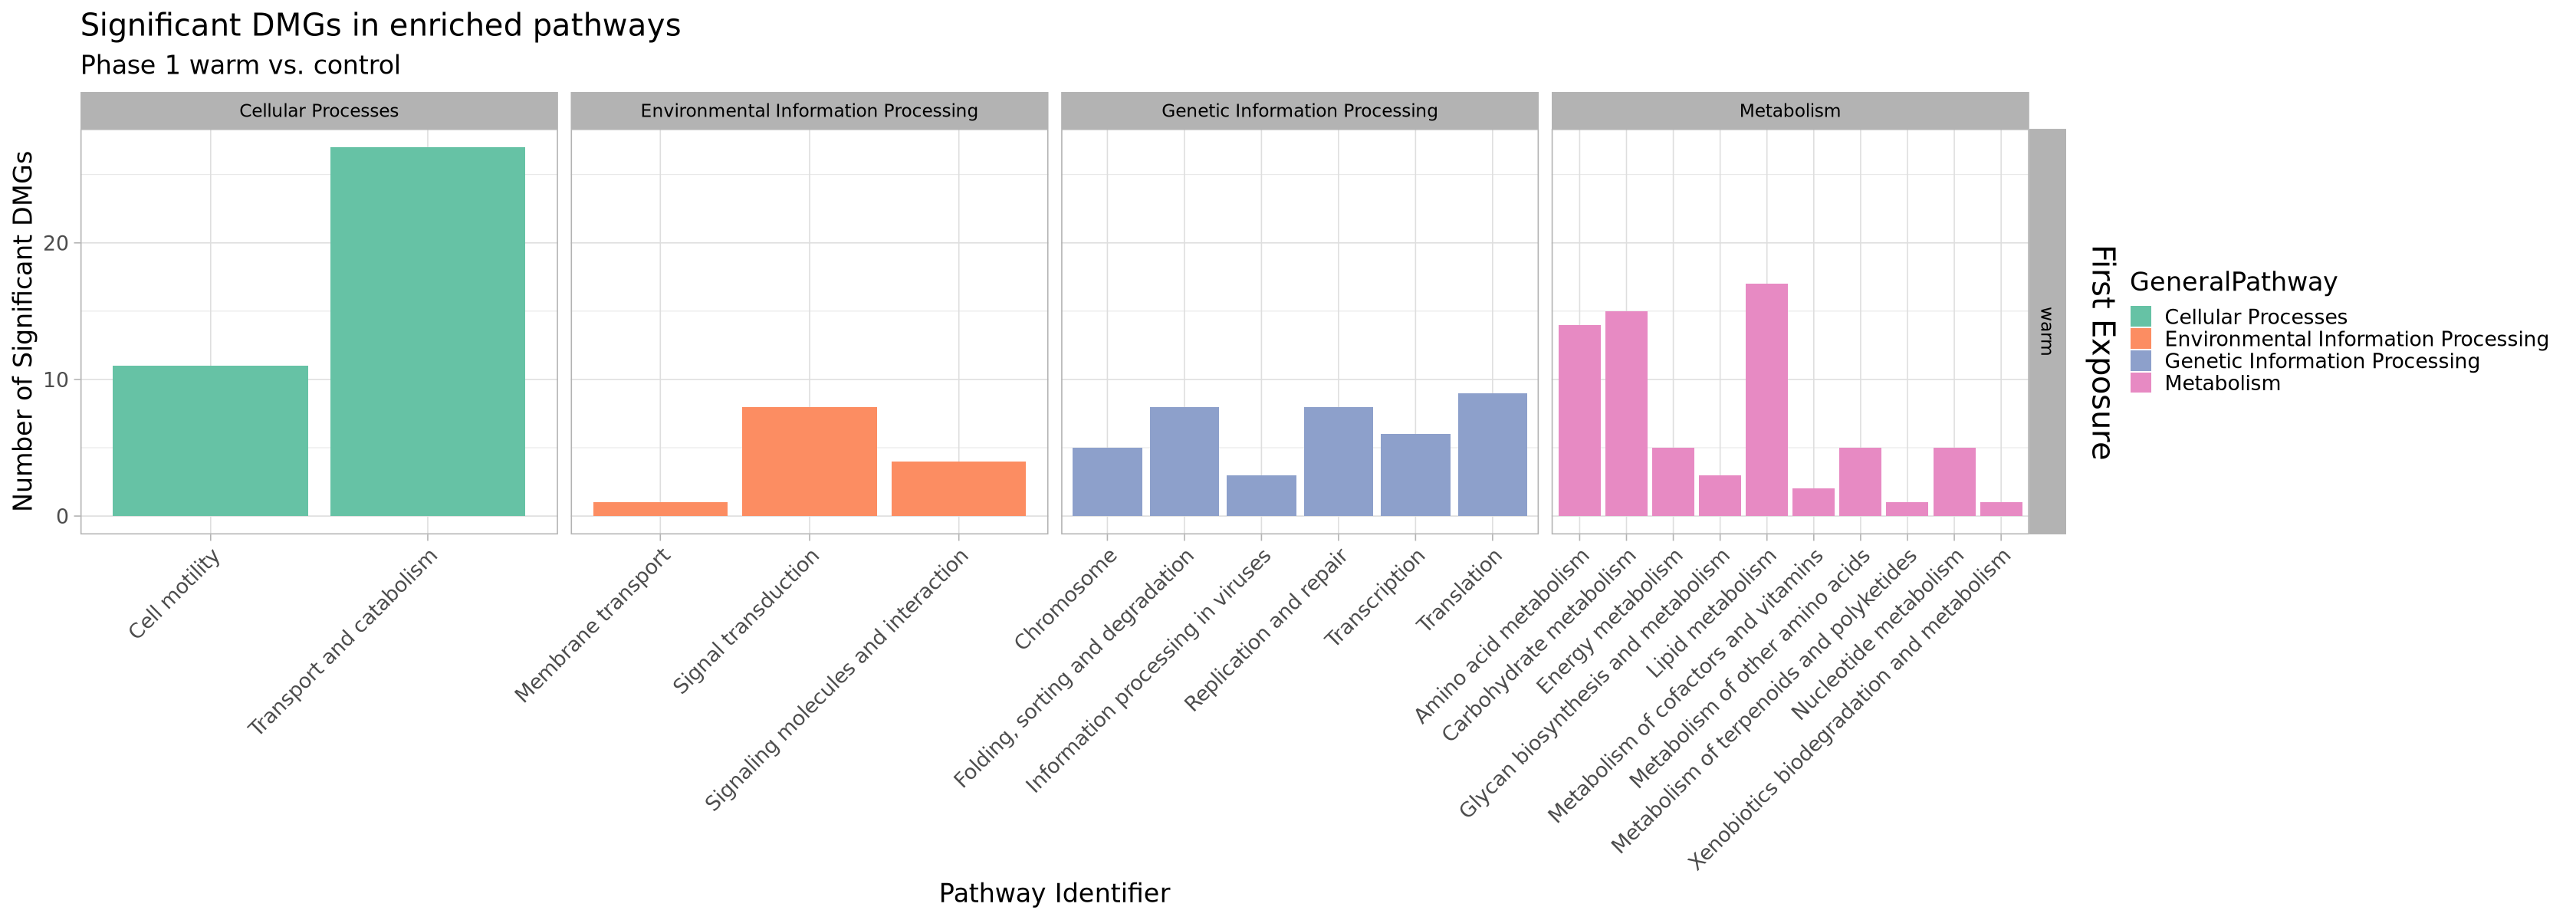

In [99]:
p1_wc_kegg_plot <- ggplot(data= result_df_merged, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar() + 
#coord_flip() +
theme_light(base_size=20) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(direction~GeneralPathway, scales='free_x') +
theme(axis.text.x = element_text(angle = 45, hjust=1), 
      legend.box.margin=margin(l=20),
      plot.tag=element_text(angle=-90),
      plot.tag.position=c(0.82, 0.62)) +
labs(title = 'Significant DMGs in enriched pathways', subtitle = 'Phase 1 warm vs. control', y = 'Number of Significant DMGs', 
    x = 'Pathway Identifier', tag='First Exposure')

p1_wc_kegg_plot

now need to do the same thing for phase 1 hypoxic, phase 2 hypoxic or control

## unfiltered DESeq KEGG analysis - CE Phase 1 Hypoxic
still looking at significantly differentially methylated genes for phase 1 warm vs. control, but now genes get assigned NA for adjusted p-values *only* when the gene has low counts (so this now includes outliers, instead of assigning outliers NA), therefore, different genes will be kept in the analysis for enriched pathways

looking at **phase 1 hypoxic, phase 2 hypoxic or control**

In [41]:
# load in data frame
unfiltered_p1h <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_sig_genes/unfiltered_lfc_p1h_hc.csv')

# select only needed columns
unfilter_df <- select(unfiltered_p1h, X, log2FoldChange, padj)

# KEGG uses entrez IDs, which are my ensembl IDs without the 'LOC' in front of them, so need to convert those
unfilter_df$X <- substr(unfilter_df$X, start = 4, stop = nchar(unfilter_df$X))

# renaming columns
colnames(unfilter_df) <- c('gene', 'lfc', 'padj')

head(unfilter_df)

gene      lfc         padj
1 111120752 -0.23790209 NA  
2 111109452  0.31180570  1  
3 111124802 -0.07839417  1  
4 111101273 -0.05650996  1  
5 111101250 -0.04906065  1  
6 111101262 -0.07049632  1

In [42]:
# creating numeric vector for kegg object
kegg_gene_list <- unfilter_df$lfc
names(kegg_gene_list) <- unfilter_df$gene

# omitting anything with NA in a cell
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list)

111108235 111109525 111124824 111133240 111119327 111130099 
 2.953389  2.397251  2.394202  2.304038  2.243978  2.236989

[1] "numeric"

In [43]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (3.69% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [44]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,15)

ID       Description                              setSize
cvn00270 cvn00270 Cysteine and methionine metabolism        43    
cvn00592 cvn00592 alpha-Linolenic acid metabolism           11    
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids   18    
cvn03082 cvn03082 ATP-dependent chromatin remodeling        69    
cvn04120 cvn04120 Ubiquitin mediated proteolysis           117    
cvn00100 cvn00100 Steroid biosynthesis                      10    
cvn03460 cvn03460 Fanconi anemia pathway                    41    
cvn00860 cvn00860 Porphyrin metabolism                      18    
cvn00510 cvn00510 N-Glycan biosynthesis                     33    
cvn00514 cvn00514 Other types of O-glycan biosynthesis      29    
cvn03008 cvn03008 Ribosome biogenesis in eukaryotes         57    
cvn00190 cvn00190 Oxidative phosphorylation                 53    
cvn00260 cvn00260 Glycine, serine and threonine metabolism  35    
cvn04068 cvn04068 FoxO signaling pathway                    66    
cvn03040 cvn03040 Spliceosome                               92    
         enrichmentScore NES       pvalue      p.adjust  qvalue    rank
cvn00270  0.5220963       1.739159 0.001763947 0.2134376 0.2023897 1555
cvn00592 -0.6794618      -1.724143 0.013273585 0.3214235 0.3047861 2277
cvn01040 -0.5761533      -1.680414 0.010941465 0.3214235 0.3047861 2054
cvn03082 -0.3769411      -1.489627 0.009091466 0.3214235 0.3047861 2797
cvn04120  0.3668674       1.455620 0.013281965 0.3214235 0.3047861 3046
cvn00100  0.6506083       1.526367 0.043070708 0.4599415 0.4361342 1767
cvn03460  0.4485237       1.485644 0.034640939 0.4599415 0.4361342 2809
cvn00860  0.5385620       1.460279 0.045614035 0.4599415 0.4361342  324
cvn00510 -0.4283362      -1.457691 0.030987298 0.4599415 0.4361342 3156
cvn00514  0.4717735       1.444858 0.043844857 0.4599415 0.4361342 1855
cvn03008  0.4050036       1.430987 0.039246468 0.4599415 0.4361342 2295
cvn00190 -0.3612814      -1.345653 0.032296882 0.4599415 0.4361342 3012
cvn00260  0.4508406       1.441935 0.051200000 0.4765538 0.4518866 3334
cvn04068  0.3797029       1.372240 0.060060060 0.5106954 0.4842610 1758
cvn03040  0.3442210       1.320366 0.063309353 0.5106954 0.4842610 2093
         leading_edge                  
cvn00270 tags=30%, list=12%, signal=27%
cvn00592 tags=73%, list=17%, signal=60%
cvn01040 tags=50%, list=15%, signal=42%
cvn03082 tags=41%, list=21%, signal=32%
cvn04120 tags=34%, list=23%, signal=27%
cvn00100 tags=30%, list=13%, signal=26%
cvn03460 tags=34%, list=21%, signal=27%
cvn00860 tags=22%, list=2%, signal=22% 
cvn00510 tags=45%, list=24%, signal=35%
cvn00514 tags=34%, list=14%, signal=30%
cvn03008 tags=32%, list=17%, signal=26%
cvn00190 tags=36%, list=22%, signal=28%
cvn00260 tags=43%, list=25%, signal=32%
cvn04068 tags=29%, list=13%, signal=25%
cvn03040 tags=22%, list=16%, signal=18%
         core_enrichment                                                                                                                                                                                                                                                                                                                                                                                                
cvn00270 111137596/111122141/111135192/111129934/111136621/111122163/111110831/111130865/111100699/111133693/111106176/111111318/111116065                                                                                                                                                                                                                                                                              
cvn00592 111123661/111124908/111136066/111136438/111107112/111115744/111113990/111127642                                                                                                                                                                                                                                               

In [45]:
# removes extra info on description column
kk2@result$Description <- gsub(pattern = " - Crassostrea virginica (eastern oyster)", 
                                 replacement = "", kk2@result$Description, fixed = T)
head(kk2)

ID       Description                             setSize
cvn00270 cvn00270 Cysteine and methionine metabolism       43    
cvn00592 cvn00592 alpha-Linolenic acid metabolism          11    
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids  18    
cvn03082 cvn03082 ATP-dependent chromatin remodeling       69    
cvn04120 cvn04120 Ubiquitin mediated proteolysis          117    
cvn00100 cvn00100 Steroid biosynthesis                     10    
         enrichmentScore NES       pvalue      p.adjust  qvalue    rank
cvn00270  0.5220963       1.739159 0.001763947 0.2134376 0.2023897 1555
cvn00592 -0.6794618      -1.724143 0.013273585 0.3214235 0.3047861 2277
cvn01040 -0.5761533      -1.680414 0.010941465 0.3214235 0.3047861 2054
cvn03082 -0.3769411      -1.489627 0.009091466 0.3214235 0.3047861 2797
cvn04120  0.3668674       1.455620 0.013281965 0.3214235 0.3047861 3046
cvn00100  0.6506083       1.526367 0.043070708 0.4599415 0.4361342 1767
         leading_edge                  
cvn00270 tags=30%, list=12%, signal=27%
cvn00592 tags=73%, list=17%, signal=60%
cvn01040 tags=50%, list=15%, signal=42%
cvn03082 tags=41%, list=21%, signal=32%
cvn04120 tags=34%, list=23%, signal=27%
cvn00100 tags=30%, list=13%, signal=26%
         core_enrichment                                                                                                                                                                                                                                                                                                                                                                                                
cvn00270 111137596/111122141/111135192/111129934/111136621/111122163/111110831/111130865/111100699/111133693/111106176/111111318/111116065                                                                                                                                                                                                                                                                              
cvn00592 111123661/111124908/111136066/111136438/111107112/111115744/111113990/111127642                                                                                                                                                                                                                                                                                                                                
cvn01040 111124908/111136066/111136438/111131209/111107112/111115744/111113990/111119293/111129730                                                                                                                                                                                                                                                                                                                      
cvn03082 111120915/111120504/111136148/111135329/111132974/111118535/111130322/111119035/111099792/111114842/111105716/111134187/111123066/111128754/111130152/111125973/111118359/111108477/111129852/111128560/111120856/111120594/111127973/111127274/111114783/111128559/111105834/111133731                                                                                                                        
cvn04120 111121155/111099688/111100396/111104196/111120860/111137343/111135325/111131129/111119134/111105597/111138340/111104637/111124955/111129295/111105462/111130310/111114538/111102530/111136470/111103790/111120632/111123155/111130966/111110185/111103787/111103271/111120128/111121135/111120086/111128926/111133998/111129467/111132898/111100417/111104077/111121443/111128564/111126002/111103982/111129365
cvn00100 111134862/111134947/111112479

In [46]:
# saving enriched pathways info into csv file to further investigate 
write.csv(kk2, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/unfiltered_pathways_p1h_ce.csv')

In [47]:
options(repr.plot.width=10, repr.plot.height=10)

Picking joint bandwidth of 0.136



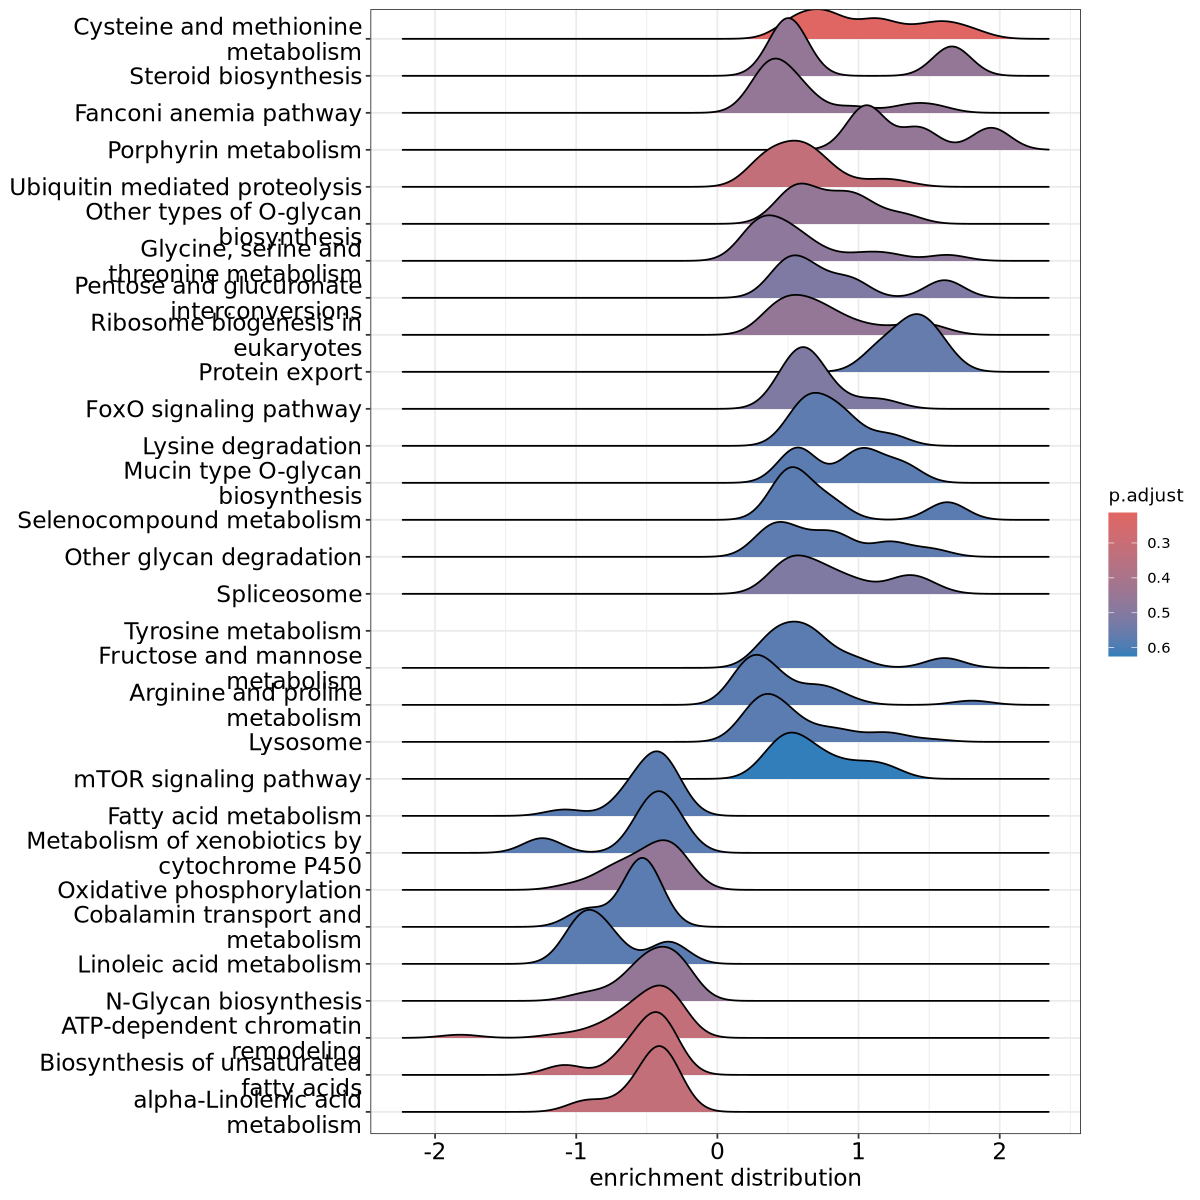

In [48]:
ridgeplot(kk2) + labs(x='enrichment distribution')

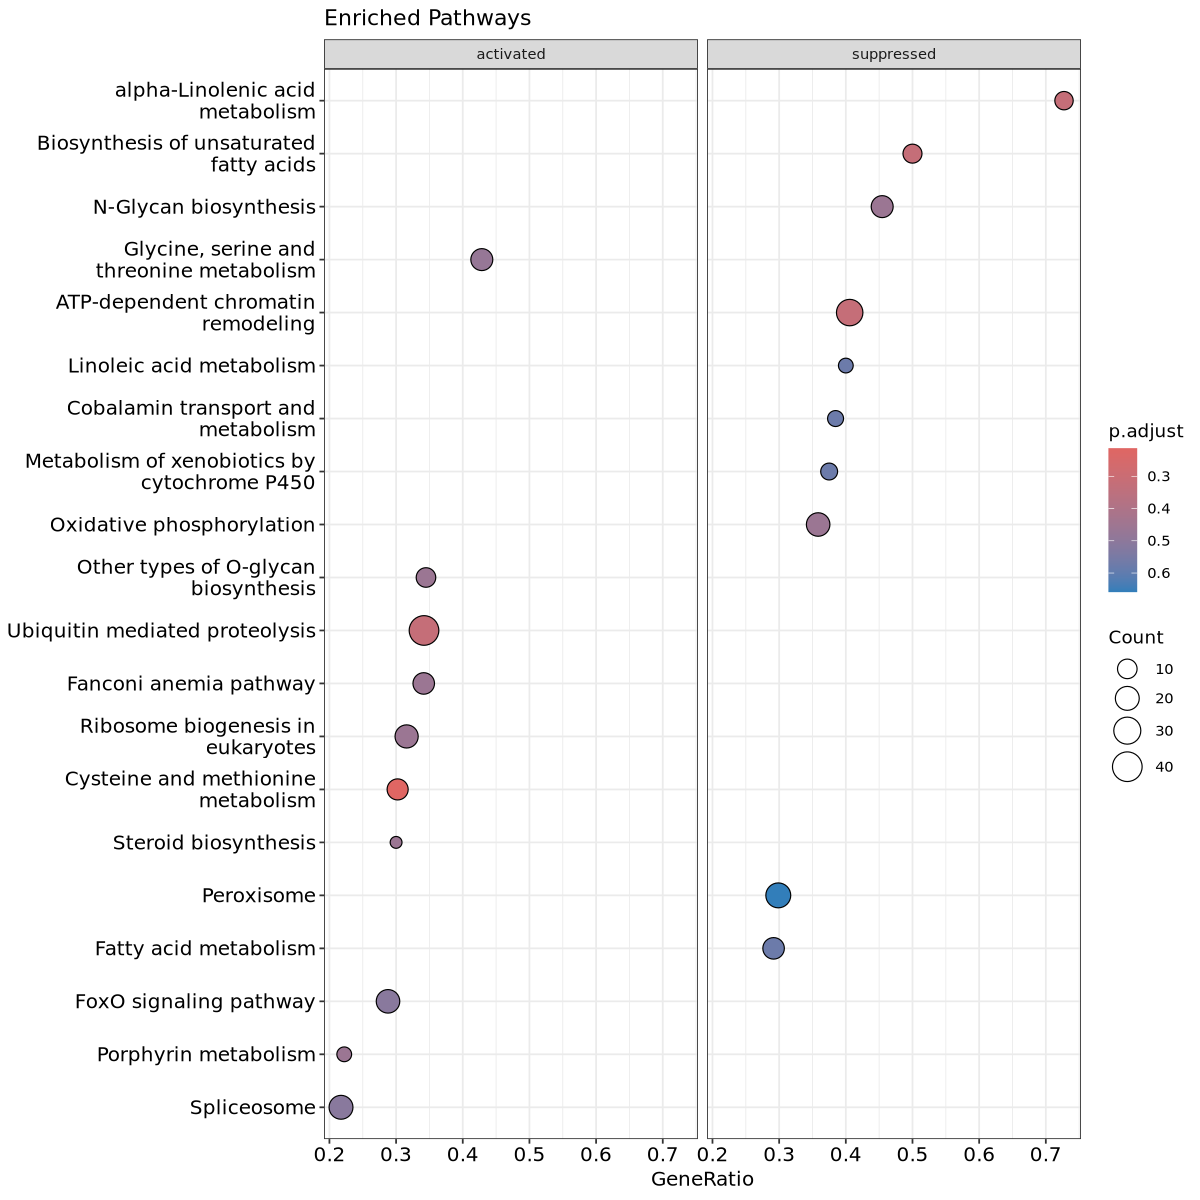

In [50]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

# activated = more methylation in phase 2 hypoxic
# suppressed = more methylation in phase 2 control

## Connecting KEGG ID to Pathway Info
From gseKEGG and in the kk2 dataframe, we can these KEGG IDs cvn##### - these correspond to the specific KEGG pathway. KEGG has hierarchel pathways, and it's useful to know what broader pathway our pathway might belong too (metabolism? organismal systems? etc...) so from help with ChatGPT, you can have R go to the URL link with info from the KEGG ID, read the line with 'CLASS' and interpret that to form new columns including our general pathway and more detailed pathway.

I've turned the code below into markdown text - runs for a long time, so after first run you should save the data frame as a csv to be able to call it when you run this again.

**function to get pathway meta data from URL link:**


In [51]:

# generated with help of ChatGPT
# Function to get pathway names
get_pathway_names <- function(kegg_id) {
  url <- paste0("http://rest.kegg.jp/get/", kegg_id)
  response <- GET(url)
  
  if (status_code(response) == 200) {
    pathway_info <- content(response, "text", encoding = "UTF-8")
    general_pathway <- NA
    detailed_pathway <- NA
    
    # Extracting general and detailed pathways from the pathway info
    lines <- strsplit(pathway_info, "\n")[[1]]
    for (line in lines) {
      if (grepl("^CLASS", line)) {
        paths <- unlist(strsplit(line, ";"))
        general_pathway <- trimws(paths[1])
        detailed_pathway <- ifelse(length(paths) > 1, trimws(paths[2]), NA)
        break
      }
    }
    
    return(list(General_Pathway = general_pathway, Detailed_Pathway = detailed_pathway))
  } else {
    cat("Failed to retrieve information for pathway:", kegg_id, "\n")
    return(NULL)
  }
}


**adding pathway meta data to data frame**

In [52]:

# generated with help of ChatGPT
# Sample dataframe with KEGG IDs
gseKEGG_df <- select(kk2_df, ID, Description, enrichmentScore)

# Function to apply to each KEGG ID in the dataframe
pathway_info <- lapply(gseKEGG_df$ID, get_pathway_names)

# Combine pathway info into a dataframe
pathway_df <- do.call(rbind, pathway_info)
colnames(pathway_df) <- c('GeneralPathway', 'DetailedPathway')

# Combine pathway info with original dataframe
gseKEGG_df <- cbind(gseKEGG_df, pathway_df)

# Rename columns for clarity
#colnames(gseKEGG_df) <- c("KEGG_ID", "General_Pathway", "Detailed_Pathway")

# Print the dataframe
head(as.data.frame(gseKEGG_df))


ID       Description                             enrichmentScore
cvn00270 cvn00270 Cysteine and methionine metabolism       0.5220963     
cvn00592 cvn00592 alpha-Linolenic acid metabolism         -0.6794618     
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids -0.5761533     
cvn03082 cvn03082 ATP-dependent chromatin remodeling      -0.3769411     
cvn04120 cvn04120 Ubiquitin mediated proteolysis           0.3668674     
cvn00100 cvn00100 Steroid biosynthesis                     0.6506083     
         GeneralPathway DetailedPathway
cvn00270 CLASS   ....   Amino ac....   
cvn00592 CLASS   ....   Lipid me....   
cvn01040 CLASS   ....   Lipid me....   
cvn03082 CLASS   ....     Chromosome   
cvn04120 CLASS   ....   Folding,....   
cvn00100 CLASS   ....   Lipid me....

now need to **clean up data frame**

In [53]:

df <- as.data.frame(gseKEGG_df)
# cleaning up GeneralPathway column to only include the pathway name and not CLASS
column <- df$GeneralPathway
column <- gsub('^CLASS\\s+', '', column)
df$GeneralPathway <- column

# also changing DetailedPathway into character instead of list to be able to write csv
df$DetailedPathway <- as.character(df$DetailedPathway)

head(df)


ID       Description                             enrichmentScore
cvn00270 cvn00270 Cysteine and methionine metabolism       0.5220963     
cvn00592 cvn00592 alpha-Linolenic acid metabolism         -0.6794618     
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids -0.5761533     
cvn03082 cvn03082 ATP-dependent chromatin remodeling      -0.3769411     
cvn04120 cvn04120 Ubiquitin mediated proteolysis           0.3668674     
cvn00100 cvn00100 Steroid biosynthesis                     0.6506083     
         GeneralPathway                 DetailedPathway                 
cvn00270 Metabolism                     Amino acid metabolism           
cvn00592 Metabolism                     Lipid metabolism                
cvn01040 Metabolism                     Lipid metabolism                
cvn03082 Genetic Information Processing Chromosome                      
cvn04120 Genetic Information Processing Folding, sorting and degradation
cvn00100 Metabolism                     Lipid metabolism

In [54]:

# write csv file
write.csv(df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p1h_ce_kegg_pathway.csv')


In [55]:
# after running above code once, can just call df from csv file
df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p1h_ce_kegg_pathway.csv')

### ggplot of pathways
With this information/meta data on the pathways, I want to do some analysis and try to generate some barplots/histograms

In [56]:
# taking out NAs
df2 <- filter(df, df$GeneralPathway!='NA')

In [57]:
options(repr.plot.width=20, repr.plot.height=10)

just plotting the data to check it out first

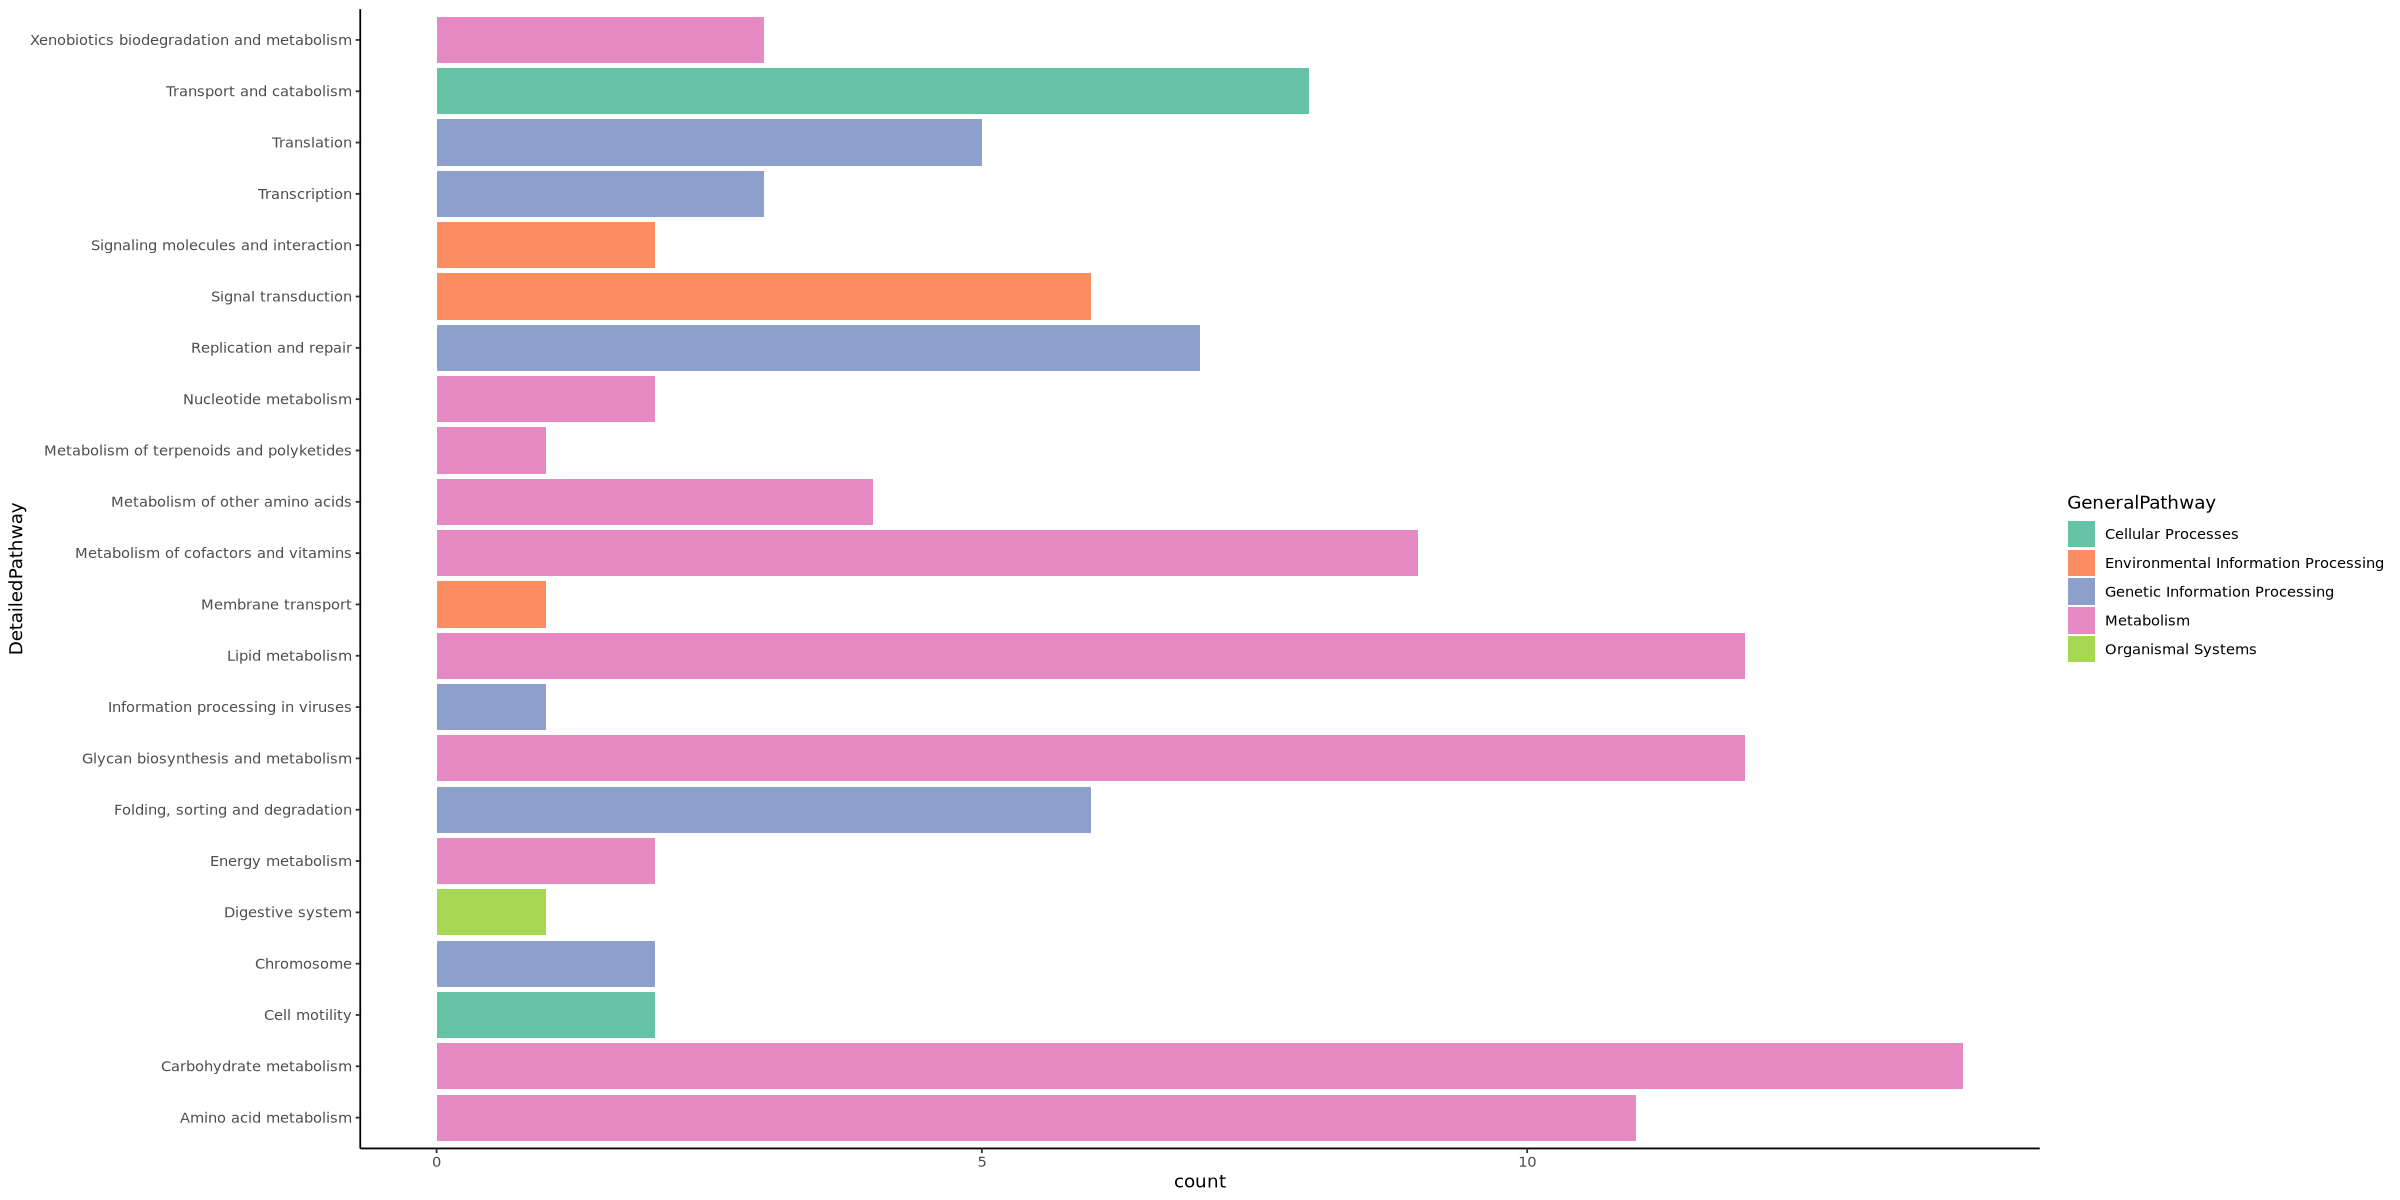

In [58]:
ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar() + 
coord_flip() +
theme_classic() + 
scale_fill_brewer(palette = 'Set2')

want to get the same general pathway bars next to each other 

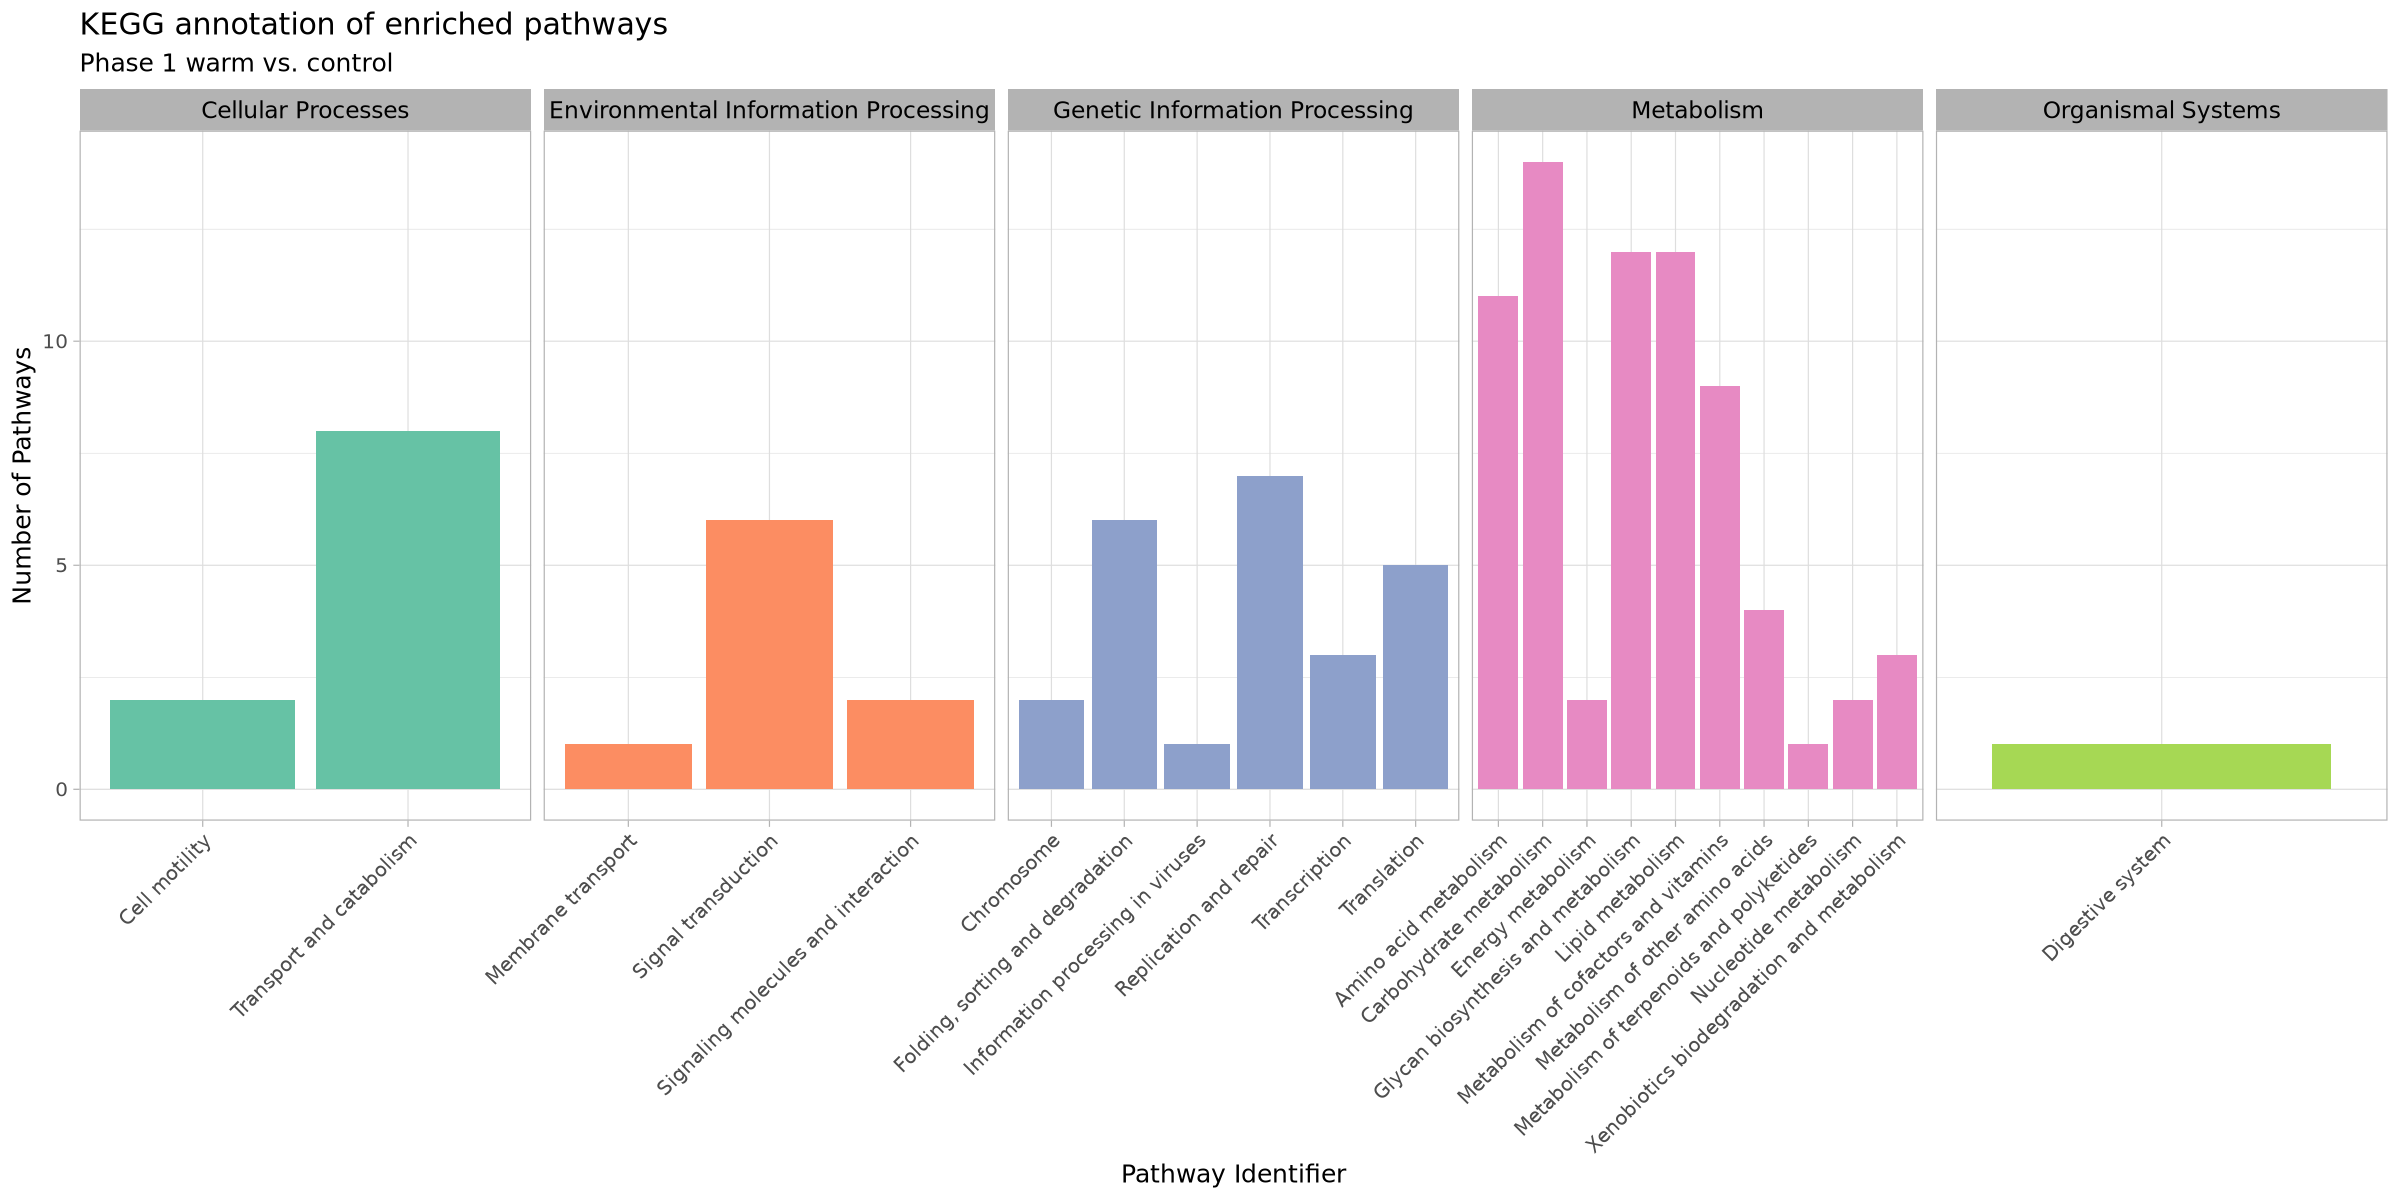

In [59]:
ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar(show.legend=FALSE) + 
#coord_flip() +
theme_light(base_size=15) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(~GeneralPathway, scales='free') +
theme(axis.text.x = element_text(angle = 45, hjust=1)) +
labs(title = 'KEGG annotation of enriched pathways', subtitle = 'Phase 1 warm vs. control', y = 'Number of Pathways', 
    x = 'Pathway Identifier')

now want to add directionality... the above plot has both warm and control pathways put together, so want to separate those out

In [63]:
# making sure R see enrichment score as a number
df2$enrichmentScore <- as.numeric(df2$enrichmentScore)

# assigning the enriched pathway to a phase based on the enrichment score
df2$direction <- ifelse(df2$enrichmentScore<0, "control", #neg ES = pathway for control
        ifelse(df2$enrichmentScore>0, "hypoxic", # pos ES = pathway for warm
        "neutral")) # don't need this, but example online had it and I can't figure out how to do this otherwise

head(df2)

X        ID       Description                             enrichmentScore
1 cvn00270 cvn00270 Cysteine and methionine metabolism       0.5220963     
2 cvn00592 cvn00592 alpha-Linolenic acid metabolism         -0.6794618     
3 cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids -0.5761533     
4 cvn03082 cvn03082 ATP-dependent chromatin remodeling      -0.3769411     
5 cvn04120 cvn04120 Ubiquitin mediated proteolysis           0.3668674     
6 cvn00100 cvn00100 Steroid biosynthesis                     0.6506083     
  GeneralPathway                 DetailedPathway                  direction
1 Metabolism                     Amino acid metabolism            hypoxic  
2 Metabolism                     Lipid metabolism                 control  
3 Metabolism                     Lipid metabolism                 control  
4 Genetic Information Processing Chromosome                       control  
5 Genetic Information Processing Folding, sorting and degradation hypoxic  
6 Metabolism                     Lipid metabolism                 hypoxic

creating another ggplot, but this time adding phase variable to the facet grid so we can see what pathways were methylated for each phase

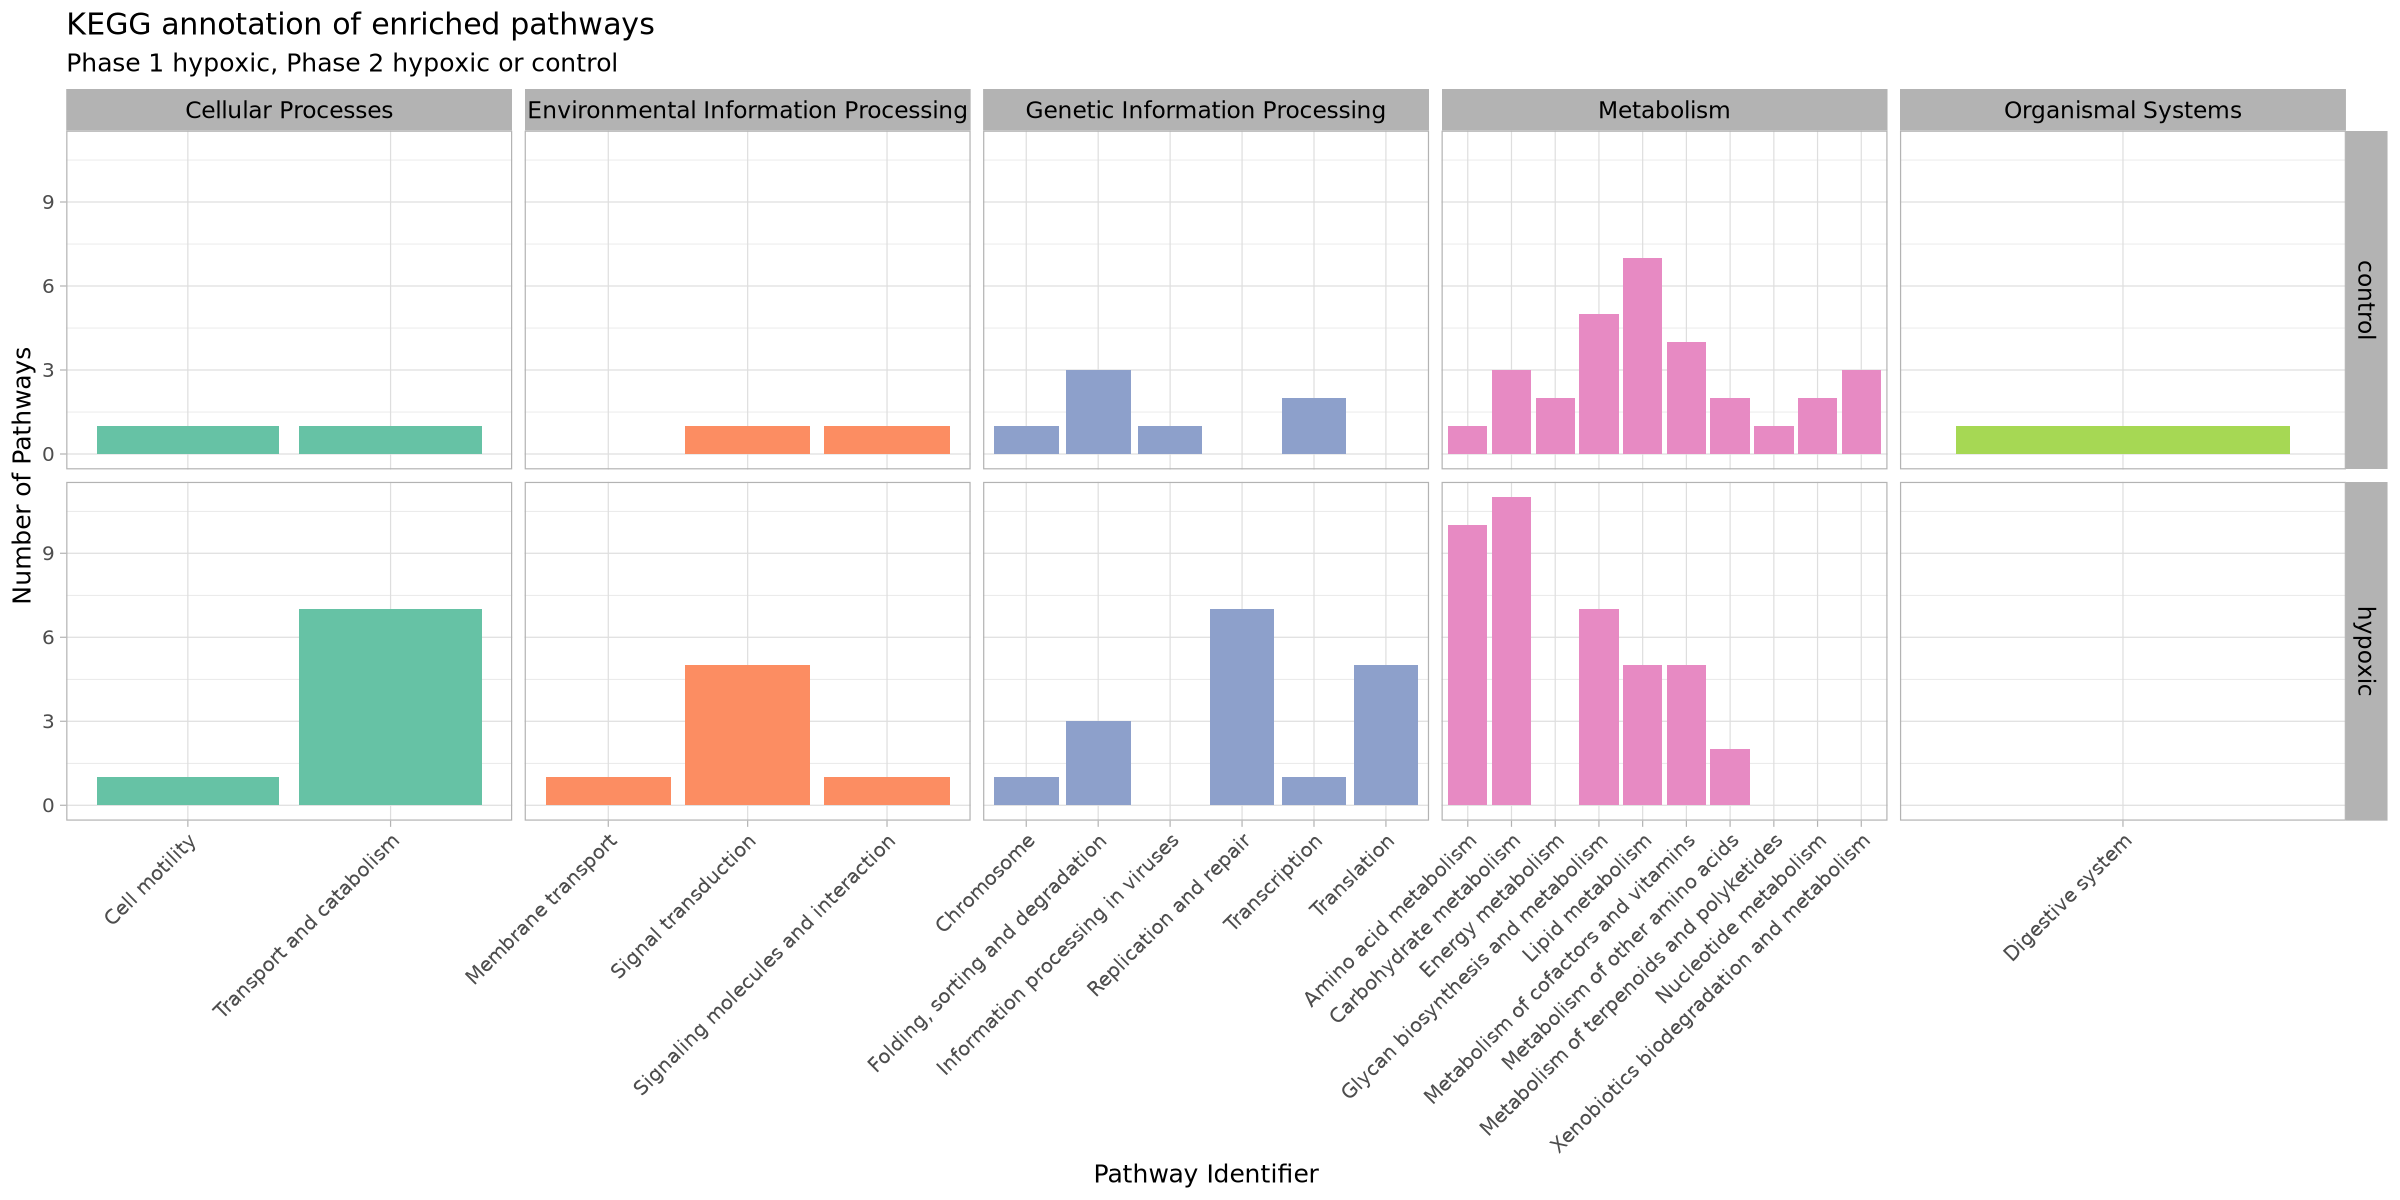

In [65]:
p1h_ce_kegg_plot <- ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar(show.legend=FALSE) + 
#coord_flip() +
theme_light(base_size=15) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(direction~GeneralPathway, scales='free_x') +
theme(axis.text.x = element_text(angle = 45, hjust=1)) +
labs(title = 'KEGG annotation of enriched pathways', subtitle = 'Phase 1 hypoxic, Phase 2 hypoxic or control', y = 'Number of Pathways', 
    x = 'Pathway Identifier')

p1h_ce_kegg_plot

In [67]:
# saving plot as pdf file

# open pdf file
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures')
pdf('p1h_ce_kegg_pathways.pdf', width=20, height=10)

# open plot
p1h_ce_kegg_plot

# close pdf file
dev.off()

png 
  2

## unfiltered DESeq KEGG analysis - all oysters phase 2 = control
still looking at significantly differentially methylated genes for phase 1 warm vs. control, but now genes get assigned NA for adjusted p-values *only* when the gene has low counts (so this now includes outliers, instead of assigning outliers NA), therefore, different genes will be kept in the analysis for enriched pathways

looking at **phase 1 hypoxic or control, phase 2 control**

In [68]:
# load in data frame
unfiltered_p2c <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_sig_genes/unfiltered_p2c.csv')

# select only needed columns
unfilter_df <- select(unfiltered_p2c, X, log2FoldChange, padj)

# KEGG uses entrez IDs, which are my ensembl IDs without the 'LOC' in front of them, so need to convert those
unfilter_df$X <- substr(unfilter_df$X, start = 4, stop = nchar(unfilter_df$X))

# renaming columns
colnames(unfilter_df) <- c('gene', 'lfc', 'padj')

head(unfilter_df)

gene      lfc         padj     
1 111120752 -0.04714912        NA
2 111109452 -0.11801920        NA
3 111124802  0.08476869 0.7777035
4 111101273 -0.19260342 0.6237348
5 111101250 -0.10155347 0.7750399
6 111101262  0.16866172 0.4393253

In [69]:
# creating numeric vector for kegg object
kegg_gene_list <- unfilter_df$lfc
names(kegg_gene_list) <- unfilter_df$gene

# omitting anything with NA in a cell
kegg_gene_list <- na.omit(kegg_gene_list)

# sort list in descending order
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

# checking that things look okay
head(kegg_gene_list)
class(kegg_gene_list)

111130870 111129122 111100699 111130929 111132673 111116941 
 1.930161  1.588239  1.505874  1.431593  1.418782  1.384263

[1] "numeric"

In [70]:
kegg_organism = 'cvn'
kk2 <- gseKEGG(geneList = kegg_gene_list,
               organism = kegg_organism,
               #minGSSize = 1,
               #maxGSSize = 800,
               pvalueCutoff = 1,
               pAdjustMethod = 'BH', #Benjamini-Hockberg FDR
               scoreType = 'std', # standard - only change for one-tailed tests
               keyType = 'kegg')

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (4.77% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [71]:
kk2_df <- as.data.frame(kk2)
kk2_df$Description <- sub(" -.*", "", kk2_df$Description)
head(kk2_df,15)

ID       Description                             setSize
cvn00592 cvn00592 alpha-Linolenic acid metabolism         11     
cvn00310 cvn00310 Lysine degradation                      31     
cvn03008 cvn03008 Ribosome biogenesis in eukaryotes       56     
cvn04146 cvn04146 Peroxisome                              77     
cvn04148 cvn04148 Efferocytosis                           98     
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids 18     
cvn04068 cvn04068 FoxO signaling pathway                  65     
cvn04150 cvn04150 mTOR signaling pathway                  81     
cvn00591 cvn00591 Linoleic acid metabolism                11     
cvn00514 cvn00514 Other types of O-glycan biosynthesis    28     
cvn04980 cvn04980 Cobalamin transport and metabolism      13     
cvn00500 cvn00500 Starch and sucrose metabolism           22     
cvn03030 cvn03030 DNA replication                         33     
cvn00100 cvn00100 Steroid biosynthesis                    10     
cvn03082 cvn03082 ATP-dependent chromatin remodeling      69     
         enrichmentScore NES       pvalue       p.adjust   qvalue     rank
cvn00592  0.7812590       1.951554 0.0003729665 0.04512895 0.04436339 1762
cvn00310 -0.4896714      -1.490488 0.0125107747 0.50871508 0.50008529 1842
cvn03008 -0.4223369      -1.458428 0.0179388325 0.50871508 0.50008529 2942
cvn04146  0.3458777       1.414407 0.0210212843 0.50871508 0.50008529 1908
cvn04148 -0.3698939      -1.407300 0.0194253269 0.50871508 0.50008529 2846
cvn01040  0.5424550       1.552808 0.0269579230 0.54365145 0.53442900 1908
cvn04068 -0.3958920      -1.421802 0.0390390390 0.62463127 0.61403509 2846
cvn04150 -0.3624939      -1.342998 0.0412979351 0.62463127 0.61403509 2010
cvn00591  0.5716292       1.427907 0.0885780886 0.70990874 0.69786592 3429
cvn00514 -0.4698378      -1.407600 0.0667779633 0.70990874 0.69786592 2568
cvn04980  0.5375633       1.383162 0.1016548463 0.70990874 0.69786592 1324
cvn00500 -0.4840436      -1.372364 0.1035058431 0.70990874 0.69786592 1722
cvn03030 -0.4421061      -1.366023 0.0858585859 0.70990874 0.69786592 3052
cvn00100 -0.5651419      -1.328536 0.1458333333 0.70990874 0.69786592   28
cvn03082  0.3332425       1.325820 0.0649533028 0.70990874 0.69786592 2571
         leading_edge                  
cvn00592 tags=73%, list=13%, signal=63%
cvn00310 tags=32%, list=14%, signal=28%
cvn03008 tags=39%, list=22%, signal=31%
cvn04146 tags=31%, list=14%, signal=27%
cvn04148 tags=32%, list=21%, signal=25%
cvn01040 tags=44%, list=14%, signal=38%
cvn04068 tags=38%, list=21%, signal=30%
cvn04150 tags=25%, list=15%, signal=21%
cvn00591 tags=55%, list=26%, signal=41%
cvn00514 tags=43%, list=19%, signal=35%
cvn04980 tags=23%, list=10%, signal=21%
cvn00500 tags=41%, list=13%, signal=36%
cvn03030 tags=52%, list=23%, signal=40%
cvn00100 tags=40%, list=0%, signal=40% 
cvn03082 tags=32%, list=19%, signal=26%
         core_enrichment                                                                                                                                                                                                                                                                                                      
cvn00592 111113990/111115744/111127642/111136066/111123661/111107112/111115745/111136438                                                                                                                                                                                                                                      
cvn00310 111115614/111109254/111130627/111121380/111130119/111107127/111125659/111110608/111112920/111128625                                                                                                                                                                                                                  
cvn03008 111104038/111122686/111123620/111128896/111134591/111103436/111102803/111105066/111119396/111123381/111112561/111110086/111119458/111125104/1111281

In [72]:
# removes extra info on description column
kk2@result$Description <- gsub(pattern = " - Crassostrea virginica (eastern oyster)", 
                                 replacement = "", kk2@result$Description, fixed = T)
head(kk2)

ID       Description                             setSize
cvn00592 cvn00592 alpha-Linolenic acid metabolism         11     
cvn00310 cvn00310 Lysine degradation                      31     
cvn03008 cvn03008 Ribosome biogenesis in eukaryotes       56     
cvn04146 cvn04146 Peroxisome                              77     
cvn04148 cvn04148 Efferocytosis                           98     
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids 18     
         enrichmentScore NES       pvalue       p.adjust   qvalue     rank
cvn00592  0.7812590       1.951554 0.0003729665 0.04512895 0.04436339 1762
cvn00310 -0.4896714      -1.490488 0.0125107747 0.50871508 0.50008529 1842
cvn03008 -0.4223369      -1.458428 0.0179388325 0.50871508 0.50008529 2942
cvn04146  0.3458777       1.414407 0.0210212843 0.50871508 0.50008529 1908
cvn04148 -0.3698939      -1.407300 0.0194253269 0.50871508 0.50008529 2846
cvn01040  0.5424550       1.552808 0.0269579230 0.54365145 0.53442900 1908
         leading_edge                  
cvn00592 tags=73%, list=13%, signal=63%
cvn00310 tags=32%, list=14%, signal=28%
cvn03008 tags=39%, list=22%, signal=31%
cvn04146 tags=31%, list=14%, signal=27%
cvn04148 tags=32%, list=21%, signal=25%
cvn01040 tags=44%, list=14%, signal=38%
         core_enrichment                                                                                                                                                                                                                                                                                                      
cvn00592 111113990/111115744/111127642/111136066/111123661/111107112/111115745/111136438                                                                                                                                                                                                                                      
cvn00310 111115614/111109254/111130627/111121380/111130119/111107127/111125659/111110608/111112920/111128625                                                                                                                                                                                                                  
cvn03008 111104038/111122686/111123620/111128896/111134591/111103436/111102803/111105066/111119396/111123381/111112561/111110086/111119458/111125104/111128153/111132055/111119695/111121480/111128265/111128132/111120056/111133163                                                                                          
cvn04146 111135891/111113990/111115744/111104085/111107393/111130560/111135288/111136066/111117608/111136587/111107606/111107112/111107850/111107491/111115745/111110283/111135201/111132335/111136438/111121658/111135419/111128430/111108763/111131209                                                                      
cvn04148 111128693/111124840/111112952/111134431/111120235/111135946/111113319/111135761/111133023/111125427/111124014/111127575/111122108/111123664/111107163/111100224/111107779/111126115/111117732/111123084/111136548/111137094/111125144/111110874/111115463/111122163/111128744/111131845/111109809/111104335/111123492
cvn01040 111113990/111115744/111129730/111136066/111107112/111115745/111136438/111131209

In [73]:
# saving enriched pathways info into csv file to further investigate 
write.csv(kk2, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/unfiltered_pathways_p2c_ce.csv')

In [74]:
options(repr.plot.width=10, repr.plot.height=10)

Picking joint bandwidth of 0.108



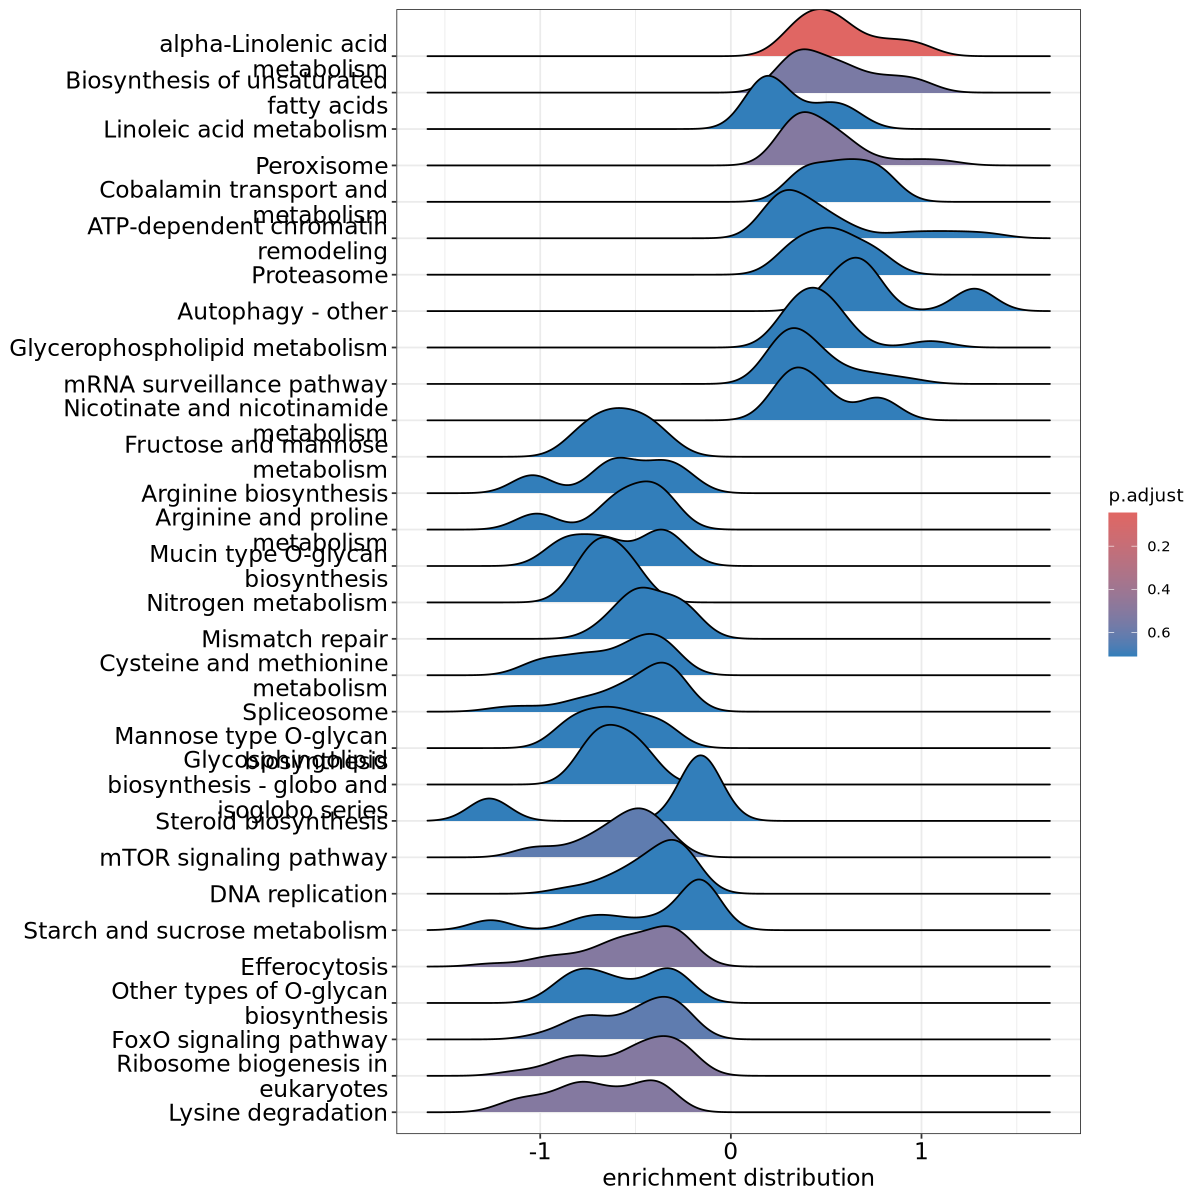

In [75]:
ridgeplot(kk2) + labs(x='enrichment distribution')

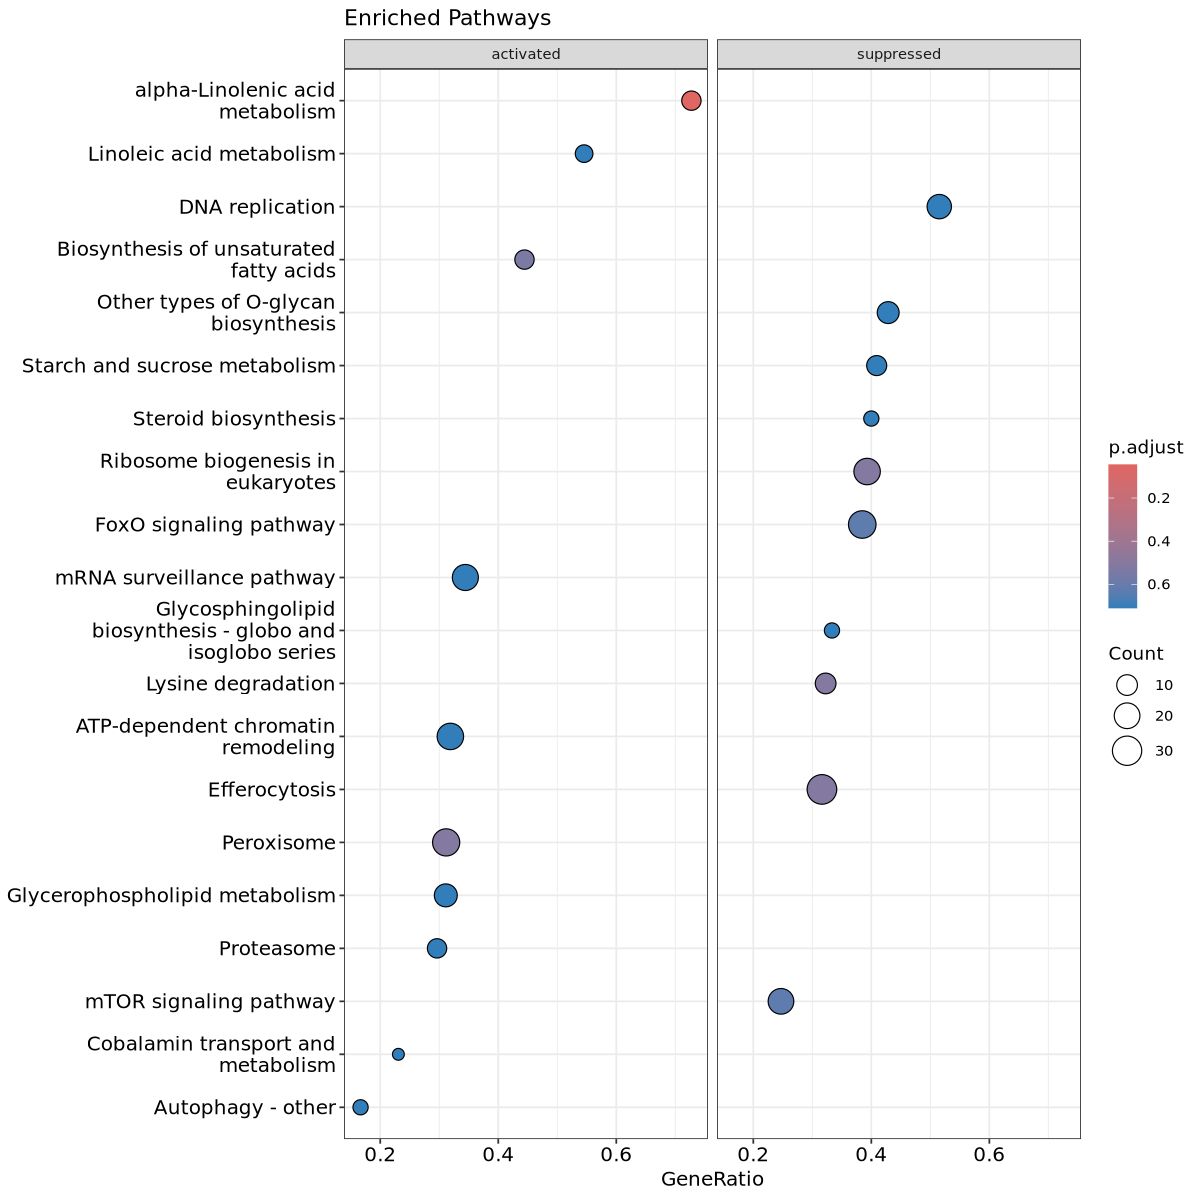

In [77]:
dotplot(kk2, showCategory = 10, title = 'Enriched Pathways', split = '.sign') + facet_grid(.~.sign)

# activated = more methylation in phase 1 hypoxic
# suppressed = more methylation in phase 1 control

## Connecting KEGG ID to Pathway Info
From gseKEGG and in the kk2 dataframe, we can these KEGG IDs cvn##### - these correspond to the specific KEGG pathway. KEGG has hierarchel pathways, and it's useful to know what broader pathway our pathway might belong too (metabolism? organismal systems? etc...) so from help with ChatGPT, you can have R go to the URL link with info from the KEGG ID, read the line with 'CLASS' and interpret that to form new columns including our general pathway and more detailed pathway.

I've turned the code below into markdown text - runs for a long time, so after first run you should save the data frame as a csv to be able to call it when you run this again.

**function to get pathway meta data from URL link:**


In [78]:

# generated with help of ChatGPT
# Function to get pathway names
get_pathway_names <- function(kegg_id) {
  url <- paste0("http://rest.kegg.jp/get/", kegg_id)
  response <- GET(url)
  
  if (status_code(response) == 200) {
    pathway_info <- content(response, "text", encoding = "UTF-8")
    general_pathway <- NA
    detailed_pathway <- NA
    
    # Extracting general and detailed pathways from the pathway info
    lines <- strsplit(pathway_info, "\n")[[1]]
    for (line in lines) {
      if (grepl("^CLASS", line)) {
        paths <- unlist(strsplit(line, ";"))
        general_pathway <- trimws(paths[1])
        detailed_pathway <- ifelse(length(paths) > 1, trimws(paths[2]), NA)
        break
      }
    }
    
    return(list(General_Pathway = general_pathway, Detailed_Pathway = detailed_pathway))
  } else {
    cat("Failed to retrieve information for pathway:", kegg_id, "\n")
    return(NULL)
  }
}


**adding pathway meta data to data frame**

In [79]:

# generated with help of ChatGPT
# Sample dataframe with KEGG IDs
gseKEGG_df <- select(kk2_df, ID, Description, enrichmentScore)

# Function to apply to each KEGG ID in the dataframe
pathway_info <- lapply(gseKEGG_df$ID, get_pathway_names)

# Combine pathway info into a dataframe
pathway_df <- do.call(rbind, pathway_info)
colnames(pathway_df) <- c('GeneralPathway', 'DetailedPathway')

# Combine pathway info with original dataframe
gseKEGG_df <- cbind(gseKEGG_df, pathway_df)

# Rename columns for clarity
#colnames(gseKEGG_df) <- c("KEGG_ID", "General_Pathway", "Detailed_Pathway")

# Print the dataframe
head(as.data.frame(gseKEGG_df))


ID       Description                             enrichmentScore
cvn00592 cvn00592 alpha-Linolenic acid metabolism          0.7812590     
cvn00310 cvn00310 Lysine degradation                      -0.4896714     
cvn03008 cvn03008 Ribosome biogenesis in eukaryotes       -0.4223369     
cvn04146 cvn04146 Peroxisome                               0.3458777     
cvn04148 cvn04148 Efferocytosis                           -0.3698939     
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids  0.5424550     
         GeneralPathway DetailedPathway
cvn00592 CLASS   ....   Lipid me....   
cvn00310 CLASS   ....   Amino ac....   
cvn03008 CLASS   ....    Translation   
cvn04146 CLASS   ....   Transpor....   
cvn04148 CLASS   ....   Transpor....   
cvn01040 CLASS   ....   Lipid me....

now need to **clean up data frame**

In [80]:

df <- as.data.frame(gseKEGG_df)
# cleaning up GeneralPathway column to only include the pathway name and not CLASS
column <- df$GeneralPathway
column <- gsub('^CLASS\\s+', '', column)
df$GeneralPathway <- column

# also changing DetailedPathway into character instead of list to be able to write csv
df$DetailedPathway <- as.character(df$DetailedPathway)

head(df)


ID       Description                             enrichmentScore
cvn00592 cvn00592 alpha-Linolenic acid metabolism          0.7812590     
cvn00310 cvn00310 Lysine degradation                      -0.4896714     
cvn03008 cvn03008 Ribosome biogenesis in eukaryotes       -0.4223369     
cvn04146 cvn04146 Peroxisome                               0.3458777     
cvn04148 cvn04148 Efferocytosis                           -0.3698939     
cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids  0.5424550     
         GeneralPathway                 DetailedPathway         
cvn00592 Metabolism                     Lipid metabolism        
cvn00310 Metabolism                     Amino acid metabolism   
cvn03008 Genetic Information Processing Translation             
cvn04146 Cellular Processes             Transport and catabolism
cvn04148 Cellular Processes             Transport and catabolism
cvn01040 Metabolism                     Lipid metabolism

In [81]:

# write csv file
write.csv(df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p2c_ce_kegg_pathway.csv')


In [82]:
# after running above code once, can just call df from csv file
df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/lfc_kegg_pathways/p2c_ce_kegg_pathway.csv')

### ggplot of pathways
With this information/meta data on the pathways, I want to do some analysis and try to generate some barplots/histograms

In [83]:
# taking out NAs
df2 <- filter(df, df$GeneralPathway!='NA')

In [84]:
options(repr.plot.width=20, repr.plot.height=10)

just plotting the data to check it out first

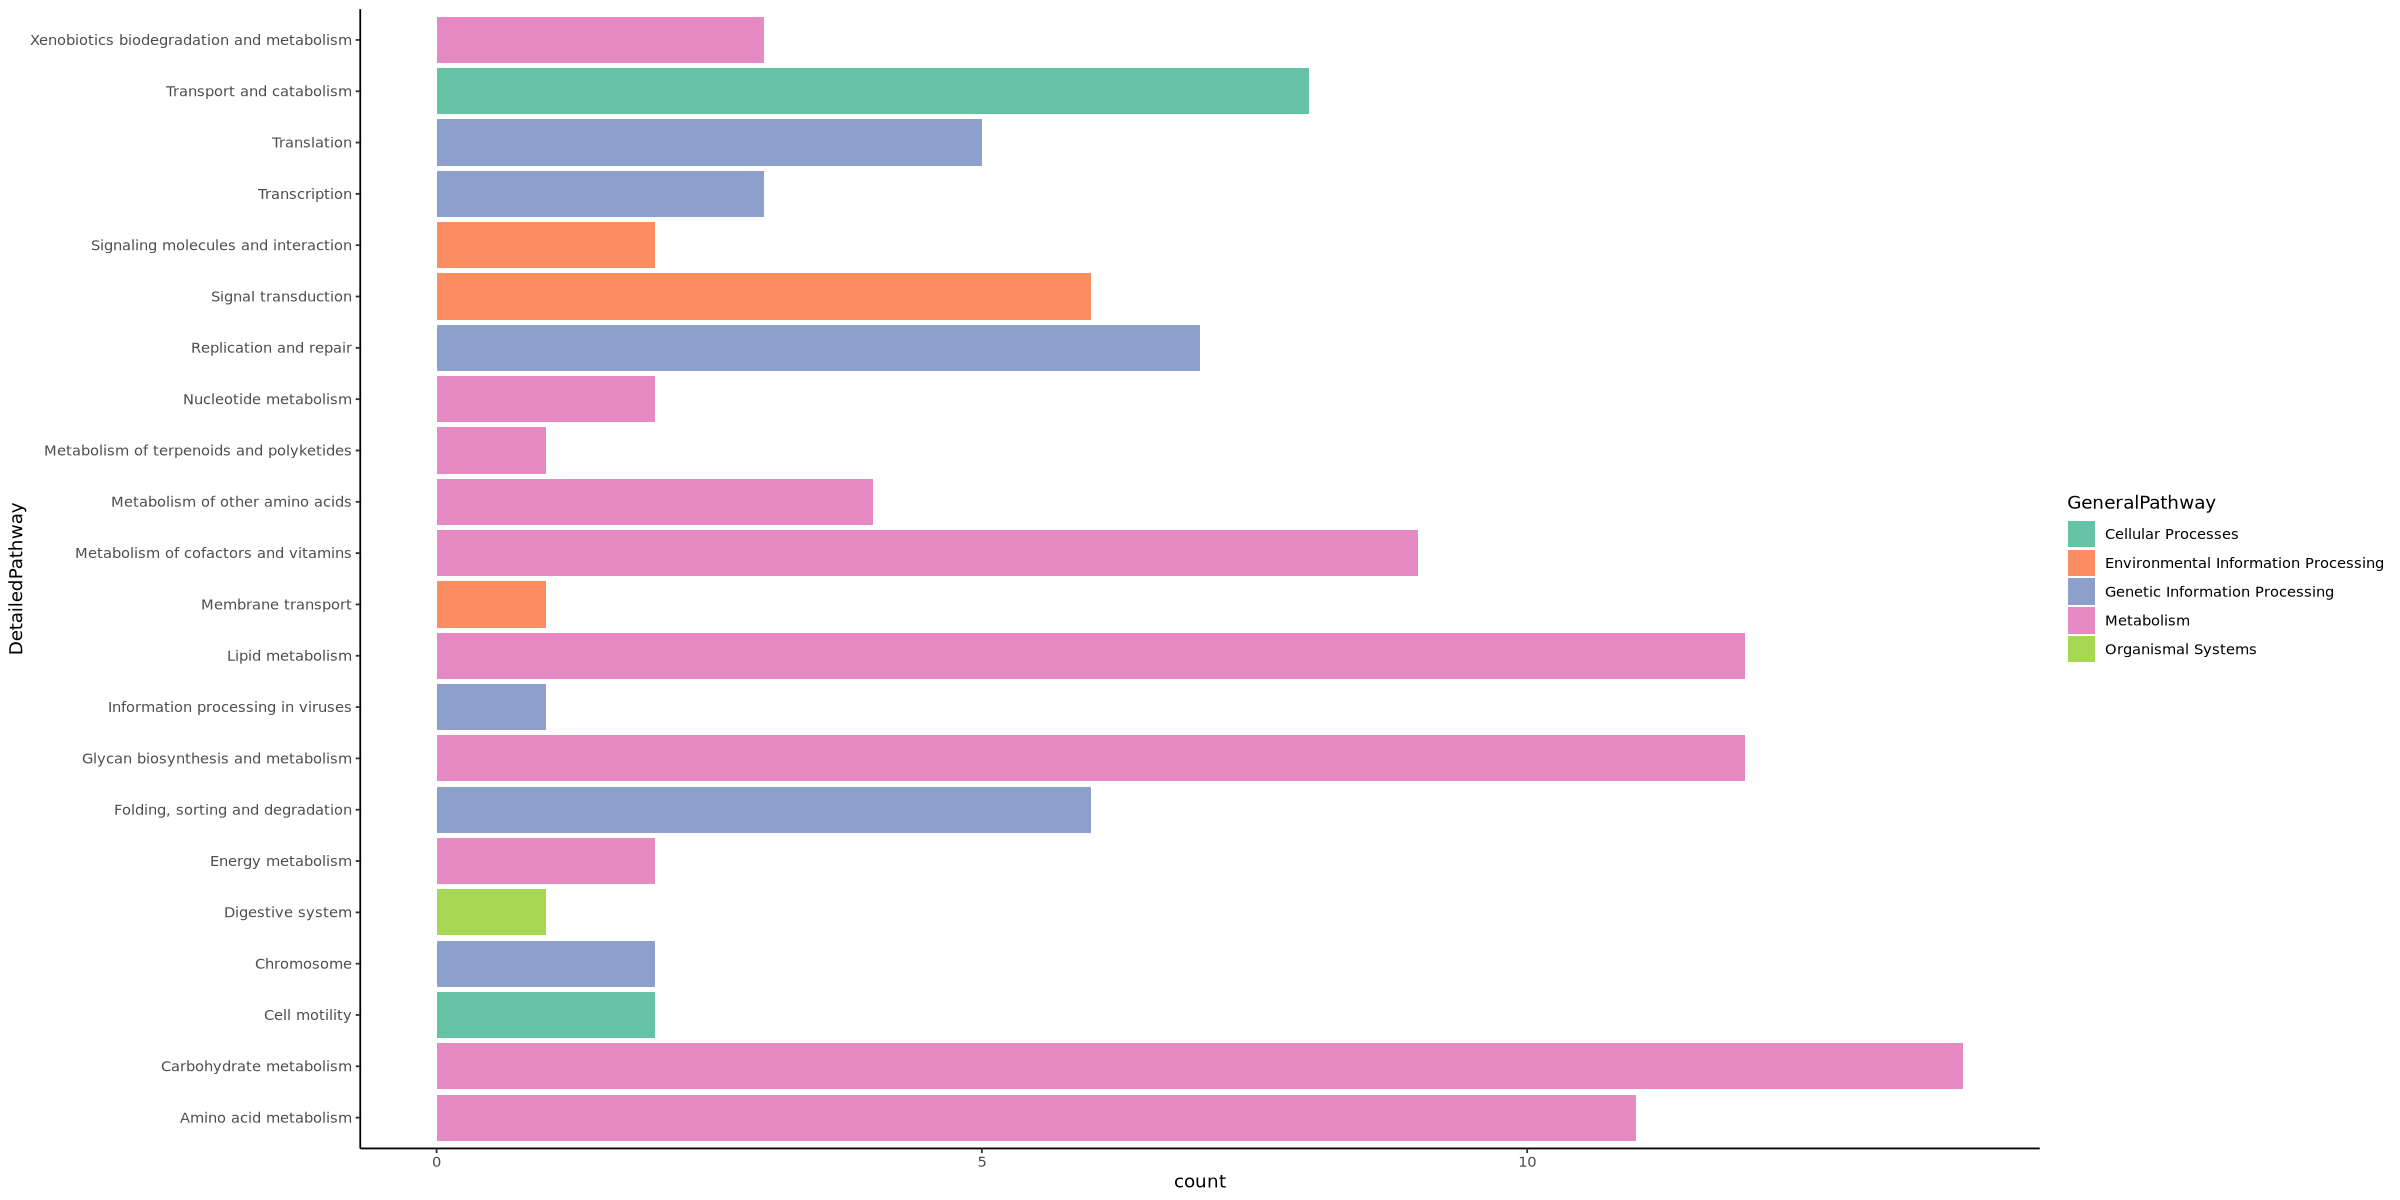

In [85]:
ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar() + 
coord_flip() +
theme_classic() + 
scale_fill_brewer(palette = 'Set2')

want to get the same general pathway bars next to each other 

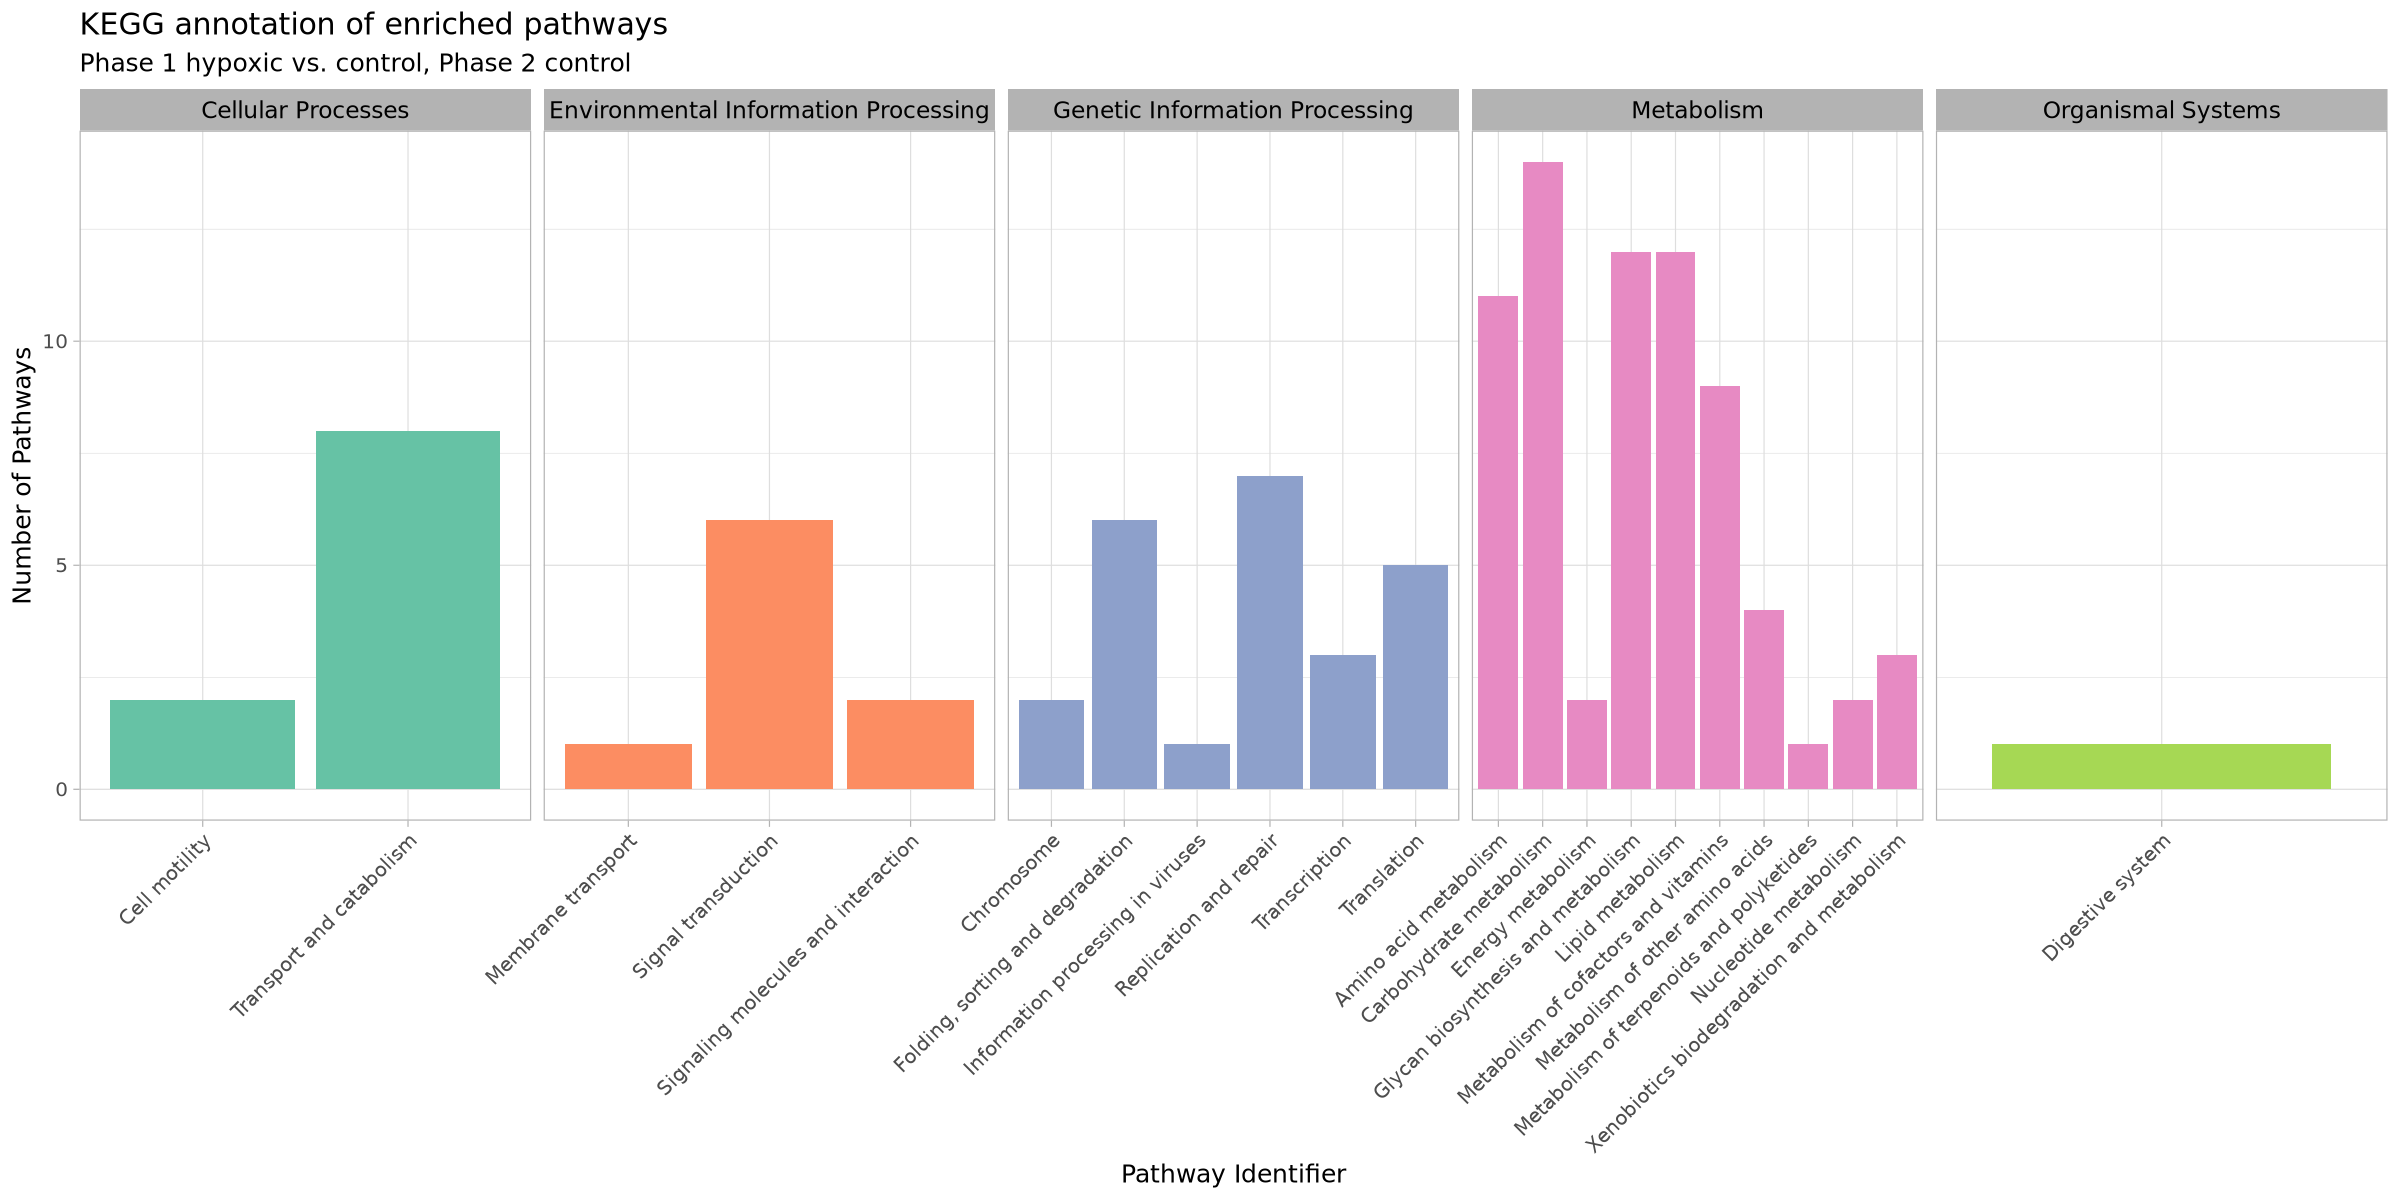

In [86]:
ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar(show.legend=FALSE) + 
#coord_flip() +
theme_light(base_size=15) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(~GeneralPathway, scales='free') +
theme(axis.text.x = element_text(angle = 45, hjust=1)) +
labs(title = 'KEGG annotation of enriched pathways', subtitle = 'Phase 1 hypoxic vs. control, Phase 2 control', y = 'Number of Pathways', 
    x = 'Pathway Identifier')

now want to add directionality... the above plot has both warm and control pathways put together, so want to separate those out

In [87]:
# making sure R see enrichment score as a number
df2$enrichmentScore <- as.numeric(df2$enrichmentScore)

# assigning the enriched pathway to a phase based on the enrichment score
df2$direction <- ifelse(df2$enrichmentScore<0, "control", #neg ES = pathway for control
        ifelse(df2$enrichmentScore>0, "hypoxic", # pos ES = pathway for warm
        "neutral")) # don't need this, but example online had it and I can't figure out how to do this otherwise

head(df2)

X        ID       Description                             enrichmentScore
1 cvn00592 cvn00592 alpha-Linolenic acid metabolism          0.7812590     
2 cvn00310 cvn00310 Lysine degradation                      -0.4896714     
3 cvn03008 cvn03008 Ribosome biogenesis in eukaryotes       -0.4223369     
4 cvn04146 cvn04146 Peroxisome                               0.3458777     
5 cvn04148 cvn04148 Efferocytosis                           -0.3698939     
6 cvn01040 cvn01040 Biosynthesis of unsaturated fatty acids  0.5424550     
  GeneralPathway                 DetailedPathway          direction
1 Metabolism                     Lipid metabolism         hypoxic  
2 Metabolism                     Amino acid metabolism    control  
3 Genetic Information Processing Translation              control  
4 Cellular Processes             Transport and catabolism hypoxic  
5 Cellular Processes             Transport and catabolism control  
6 Metabolism                     Lipid metabolism         hypoxic

creating another ggplot, but this time adding phase variable to the facet grid so we can see what pathways were methylated for each phase

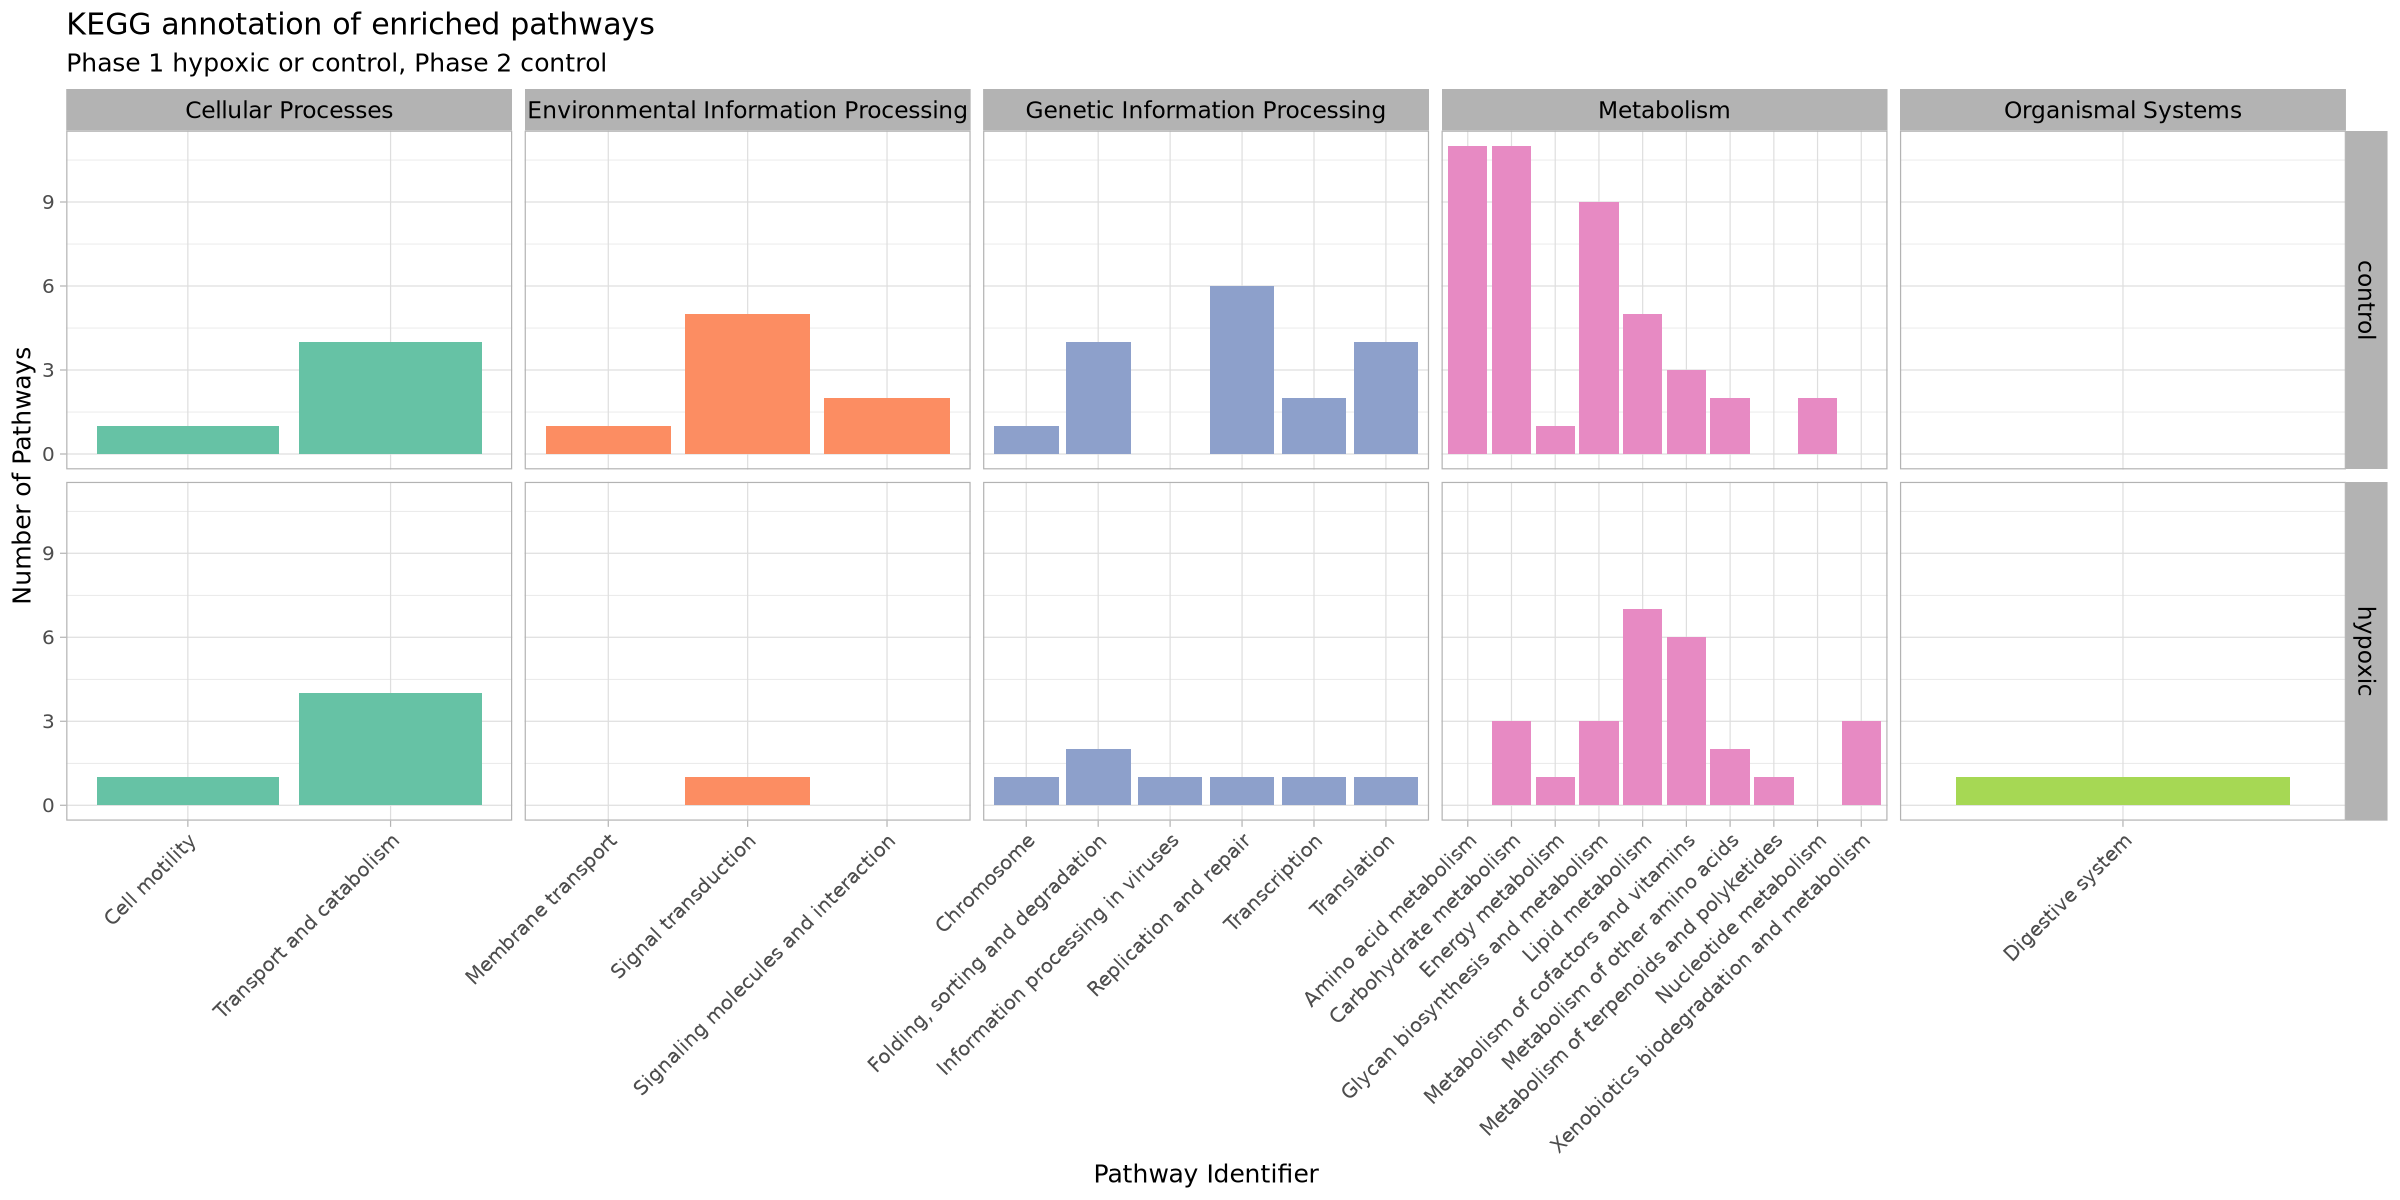

In [88]:
p2c_ce_kegg_plot <- ggplot(data= df2, aes(x = DetailedPathway, fill = GeneralPathway)) +
geom_bar(show.legend=FALSE) + 
#coord_flip() +
theme_light(base_size=15) + 
theme(strip.text = element_text(size = 14, color = "black")) +
scale_fill_brewer(palette = 'Set2') +
facet_grid(direction~GeneralPathway, scales='free_x') +
theme(axis.text.x = element_text(angle = 45, hjust=1)) +
labs(title = 'KEGG annotation of enriched pathways', subtitle = 'Phase 1 hypoxic or control, Phase 2 control', y = 'Number of Pathways', 
    x = 'Pathway Identifier')

p2c_ce_kegg_plot

not sure what to make of this... (but also remember these weren't filtered for lfc)

In [89]:
# saving plot as pdf file

# open pdf file
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures')
pdf('p2c_ce_kegg_pathways.pdf', width=20, height=10)

# open plot
p2c_ce_kegg_plot

# close pdf file
dev.off()

png 
  2